In [2]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from math import sqrt as sqrt

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, b_train),(x_test, b_test) = mnist.load_data()

In [5]:
list(set(b_train))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
x_train = x_train/255
x_test = x_test/255

x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

#One hot encoding labels
y_train = np.zeros((b_train.shape[0], 10))
y_train[np.arange(b_train.shape[0]), b_train] = 1  

y_test = np.zeros((b_test.shape[0], 10))
y_test[np.arange(b_test.shape[0]), b_test] = 1  

x_train[0].shape[2]

1

In [7]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


### Classes and functions for Layer Initialization and Model Building

In [8]:
def reLU(img):
    non_lin = np.maximum(img, 0)
    return non_lin

In [9]:
class conv_layer:
    def __init__(self, img, num_filters, filter_size, padding, stride):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.padding = padding
        self.stride = stride
        self.img = img
        #Refer to CS231n notes for logic behind this initialization. num_smaples = 60000
        self.cnn_layer = [np.true_divide(np.random.randn(self.filter_size, self.filter_size, self.img.shape[2]), sqrt(60000)) for i in range(self.num_filters)]
        self.cnn_bias = np.asarray([np.zeros([img.shape[0], img.shape[1]]) for i in range(len(self.cnn_layer))])
    
    def convolve(self, cnn_filter):
        activation_map = np.zeros([self.img.shape[0], self.img.shape[1]])
        s = 0
        for i in range(0, self.img.shape[0], self.stride):
            t = 0
            for j in range(0, self.img.shape[1], self.stride):
                z = np.zeros(cnn_filter.shape)
                z = np.asarray([[np.zeros(self.img.shape[2]) if m not in range(self.img.shape[0]) or n not in range(self.img.shape[1]) 
                      else self.img[m, n] for n in range(j - int(cnn_filter.shape[0]/2), j + int(cnn_filter.shape[0]/2) + 1)] 
                                for m in range(i - int(cnn_filter.shape[0]/2), i + int(cnn_filter.shape[0]/2) + 1)])
                buffer_output = np.asarray([max(0, z[m, n, l]*cnn_filter[m, n, l]) for m, n, l in np.ndindex(cnn_filter.shape)])
                activation_map[s, t] = np.sum(buffer_output)
                t += self.stride
            s += self.stride
        return activation_map
    
    def forward_pass(self, img):
        layer_output = [np.zeros([img.shape[0], img.shape[1]]) for i in range(len(self.cnn_layer))]
        for x, cnn_filter in enumerate(self.cnn_layer):
            layer_output[x] = self.convolve(cnn_filter)
            example_map = reLU(layer_output[x])
#             print(str(x) + " filter", example_map.shape)
            plt.figure()
            plt.imshow(example_map)
        layer_output = np.add(np.dstack(layer_output), self.cnn_bias.transpose())
#         print(layer_output.shape)
        return layer_output
        

In [33]:
def max_pooling_layer(img, filter_size, stride):
    out_size = int((img.shape[0] - filter_size)/stride) + 1
#     layer_output = np.zeros([out_size, out_size]) #np.zeros([int(img.shape[0]/2), int(img.shape[0]/2)]) #Dividing by two because filter_size=2 and stride=2
    full_layer_output = []
    full_layer_backward = []
    img_layers = [img[:,:,i] for i in range(img.shape[2])]
    plt.figure()
    plt.imshow(img_layers[0])
    for layer in img_layers:
        layer_output = np.zeros([out_size, out_size])
        layer_backward_output = np.zeros([layer.shape[0], layer.shape[1]])
        print("LOShape::", layer_output.shape)
        s = 0
        for i in range(0, layer.shape[0], stride):
            t = 0
            for j in range(0, layer.shape[1], stride):
#                 print(i, j)
                if filter_size%2 !=0 :
                    z = np.asarray([[0 if m not in range(layer.shape[0]) or n not in range(layer.shape[1]) 
                                else layer[m, n] for n in range(j - int(filter_size/2), j + int(filter_size/2) + 1)]
                               for m in range(i - int(filter_size/2), i + int(filter_size/2) + 1)])
                else:
                    z = np.asarray([[0 if m not in range(layer.shape[0]) or n not in range(layer.shape[1]) 
                                else layer[m, n] for n in range(j, j + int(filter_size/2) + 1)]
                               for m in range(i, i + int(filter_size/2) + 1)])
#                 print("Window from ({}, {}) to ({}, {})".format(i, j, i + int(filter_size/2), j + int(filter_size/2)))
                plt.figure()
                plt.imshow(z)
                buffer_output = np.max(z)
                if (t < out_size) and (s < out_size):
                    layer_output[s, t] = buffer_output
                layer_backward_output[s, t] = buffer_output 
                t += stride
            s += stride
        full_layer_output.append(layer_output)
        full_layer_backward.append(layer_backward_output)
    
    for x, max_pooling_filter in enumerate(full_layer_output):
        example_map = max_pooling_filter
#         print(str(x) + " filter", example_map.shape)
        plt.figure()
        plt.imshow(example_map)
    full_layer_output = np.dstack(full_layer_output)
    full_layer_backward = np.dstack(full_layer_backward)
    print("Shape after max_pooling layer::", full_layer_output.shape)
    return full_layer_output, full_layer_backward

In [34]:
class fully_connected_layer:
    def __init__(self, img, num_classes):
        self.fc_input = img.reshape((img.shape[0] * img.shape[1] * img.shape[2], 1))
        self.fc_layer = np.true_divide(np.random.rand(num_classes, self.fc_input.shape[0]), sqrt(60000))
        self.fc_bias = np.zeros((num_classes, 1))
    
    def forward_pass(self, img):
        fc_input = img.reshape((img.shape[0] * img.shape[1] * img.shape[2], 1))
        fc_output = reLU(np.add(np.matmul(self.fc_layer, fc_input), self.fc_bias))
        print("FC Output Shape::", fc_output.shape)
        return fc_output

In [35]:
def dropout_layer(img, p):
    U1 = (np.random.rand(*img.shape) < p) / p # first dropout mask. Notice /p!
    img *= U1 # drop!
    return img

In [36]:
def softmax_layer(x):
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)), axis=0)

LOShape:: (14, 14)


c:\users\skrishnamurthy2\appdata\local\continuum\anaconda3\envs\tensorflow_3.5\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


LOShape:: (14, 14)
LOShape:: (14, 14)
Shape after max_pooling layer:: (14, 14, 3)
FC Output Shape:: (10, 1)


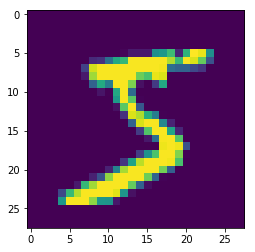

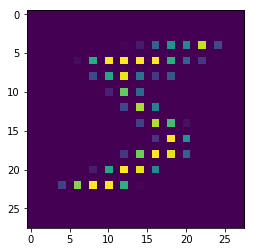

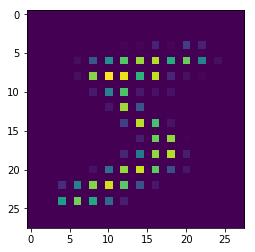

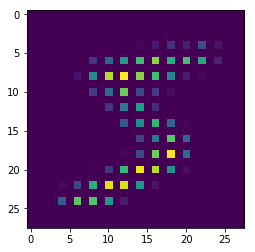

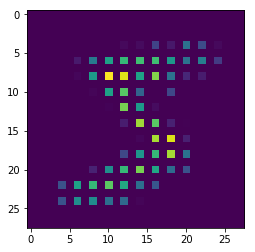

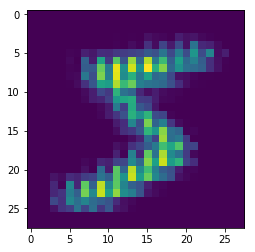

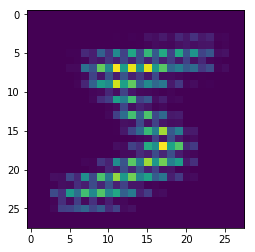

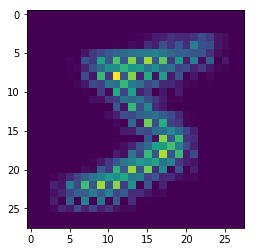

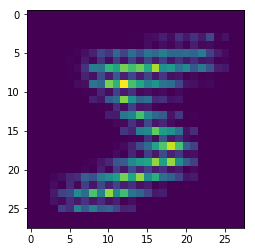

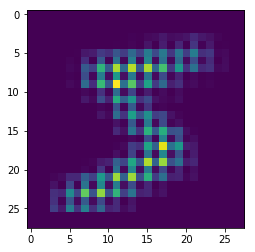

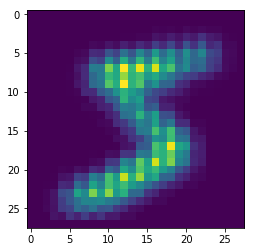

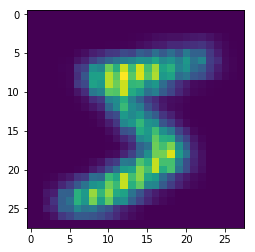

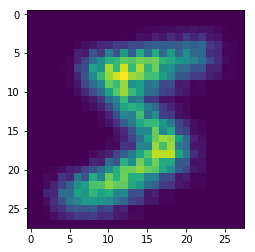

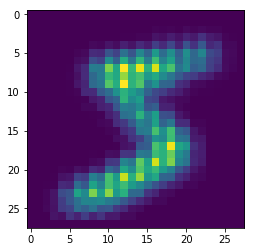

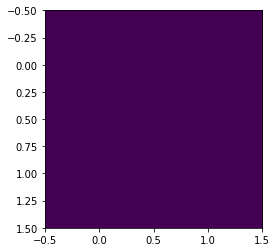

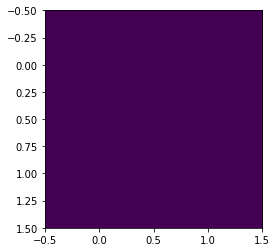

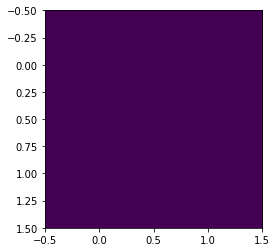

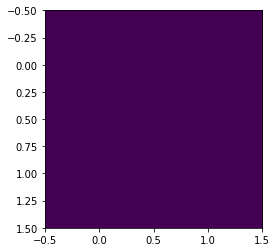

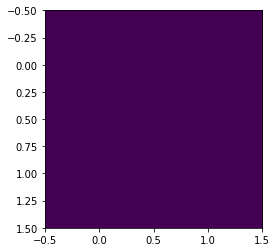

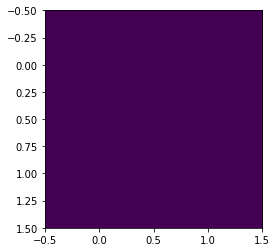

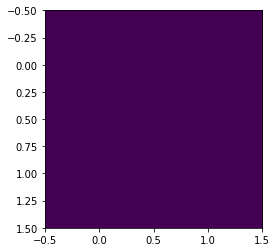

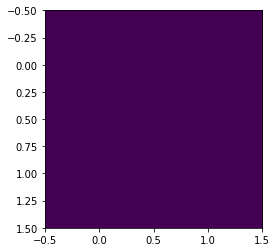

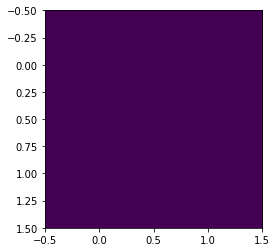

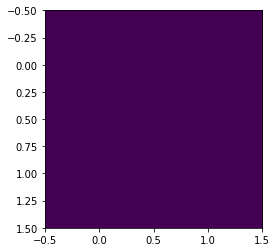

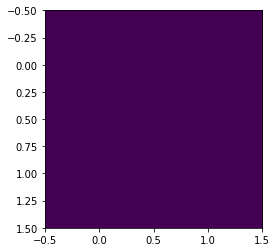

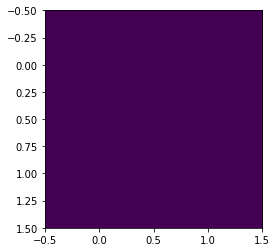

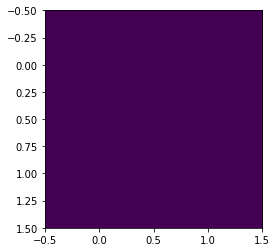

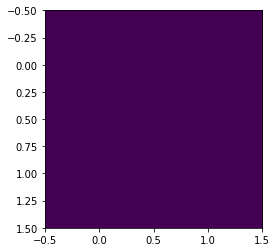

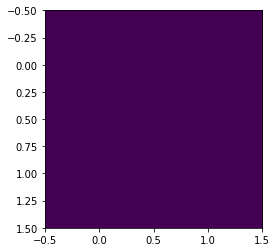

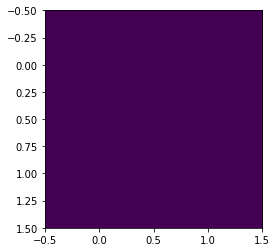

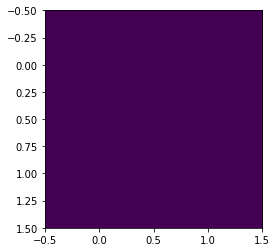

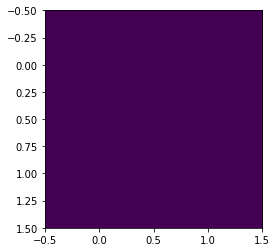

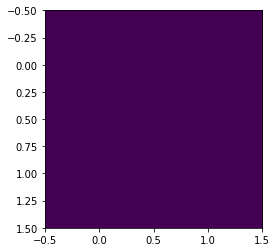

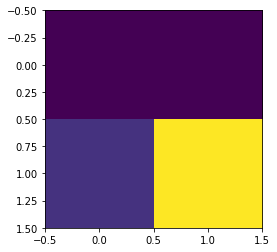

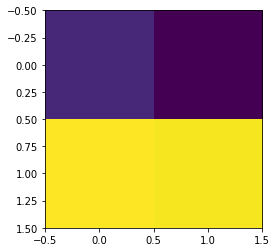

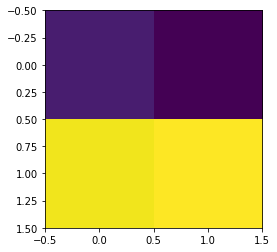

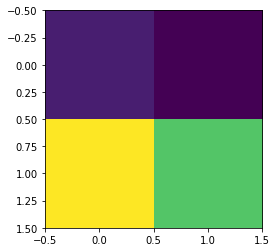

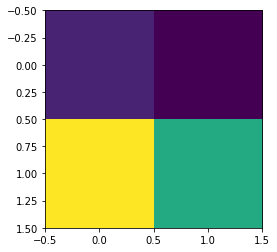

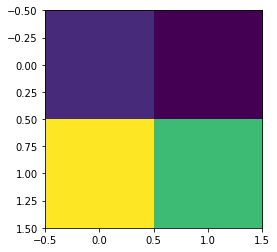

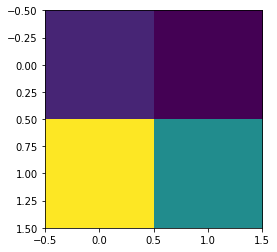

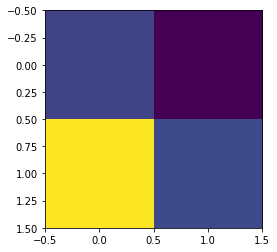

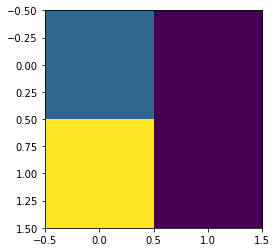

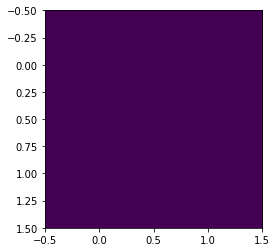

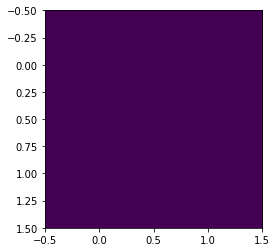

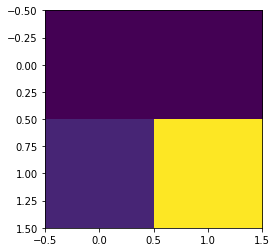

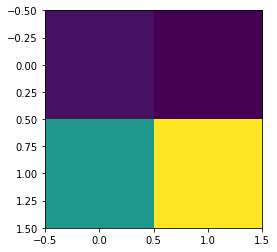

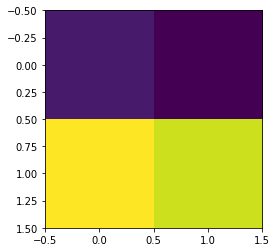

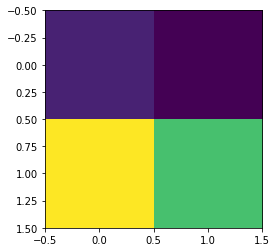

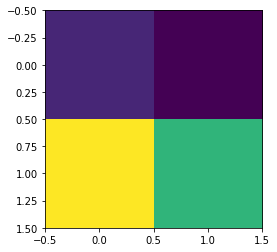

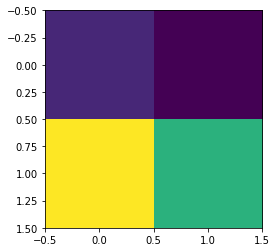

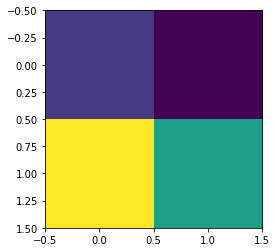

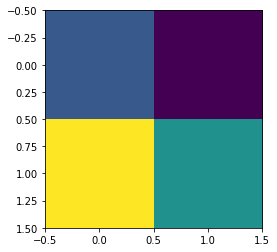

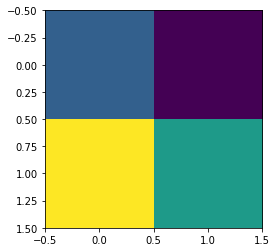

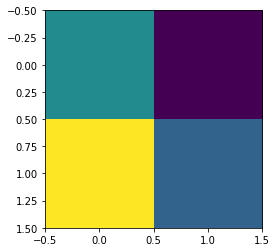

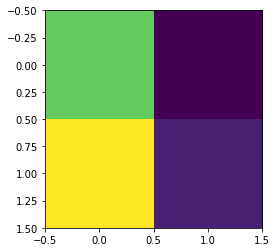

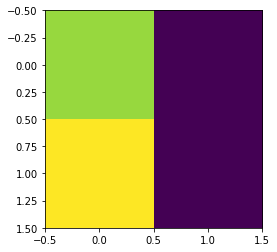

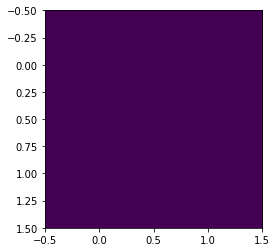

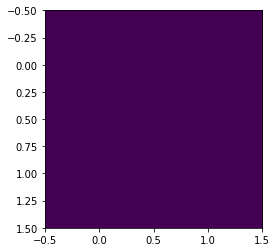

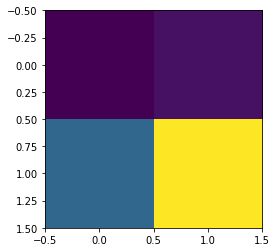

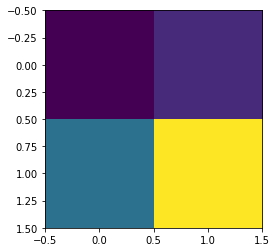

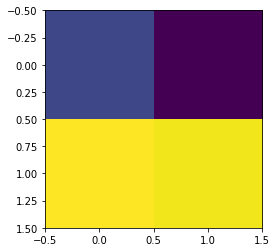

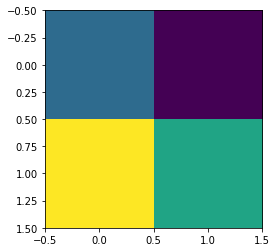

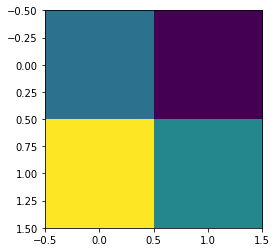

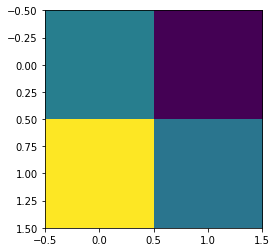

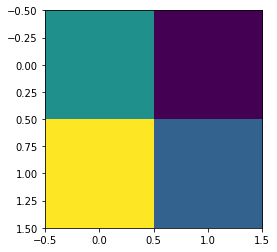

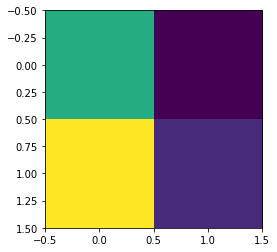

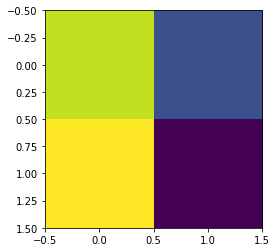

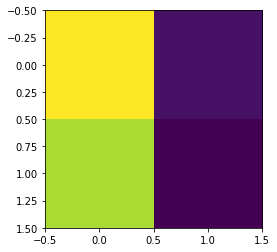

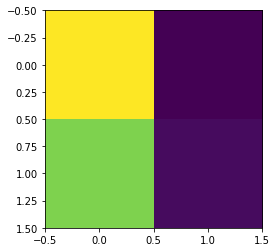

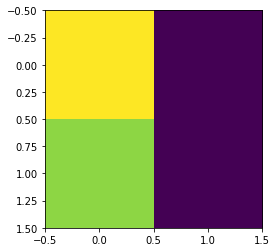

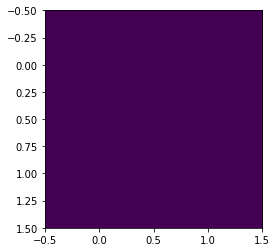

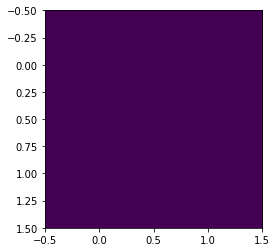

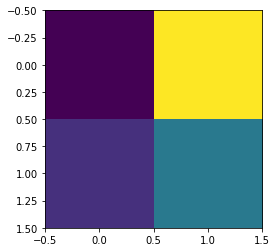

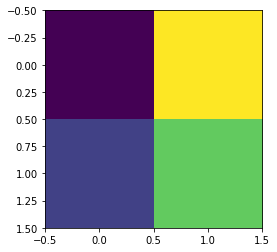

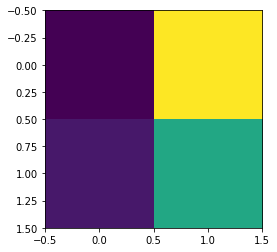

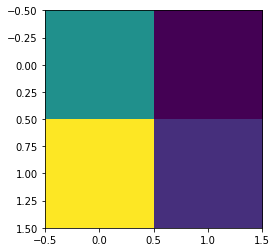

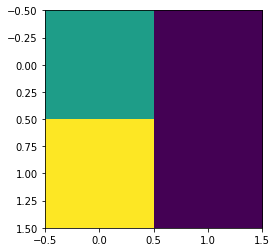

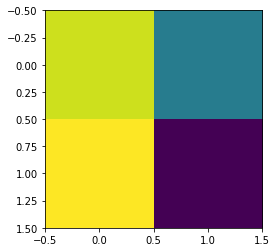

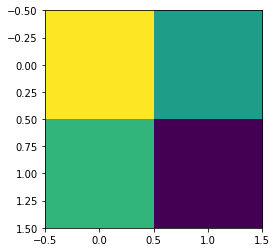

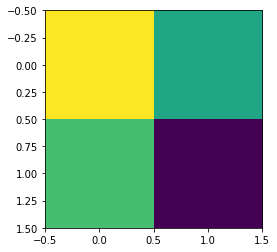

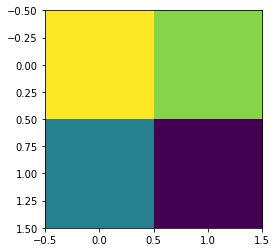

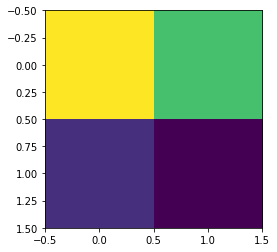

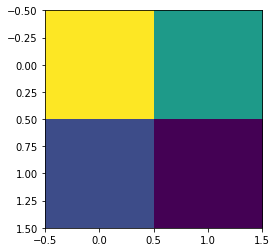

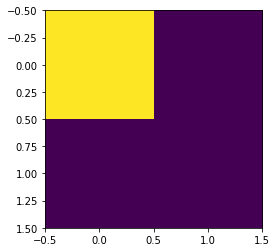

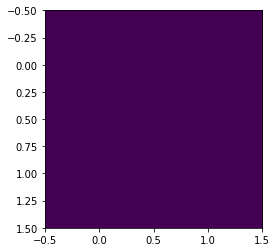

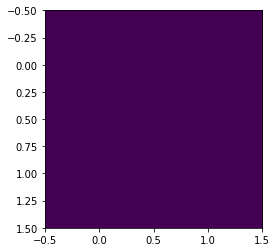

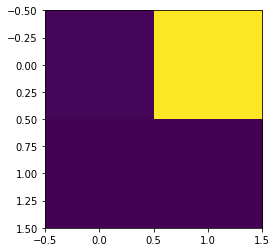

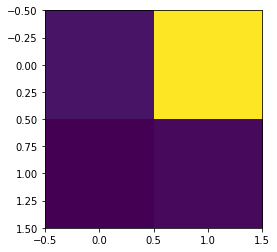

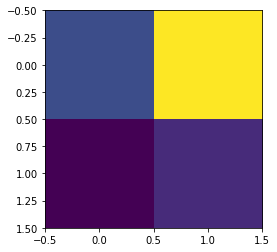

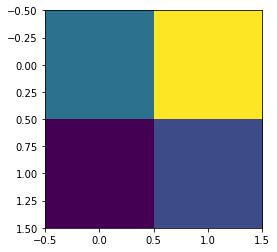

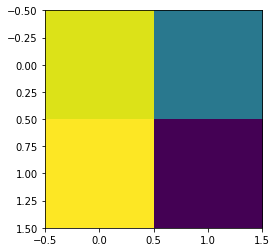

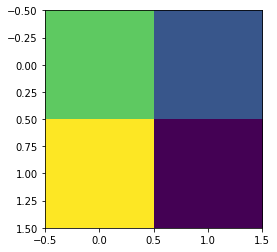

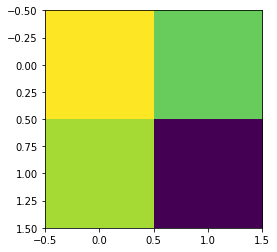

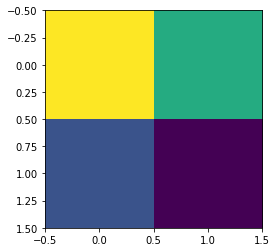

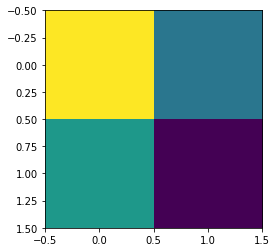

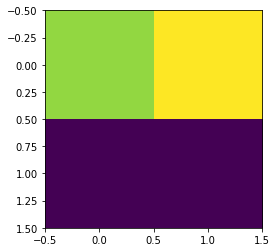

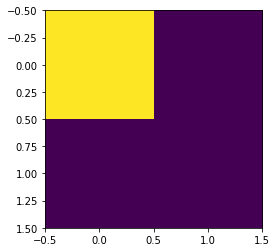

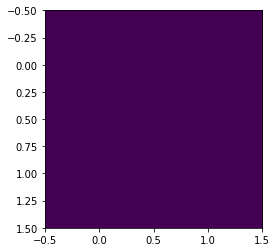

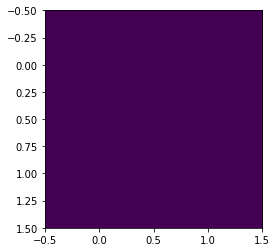

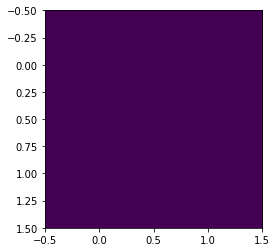

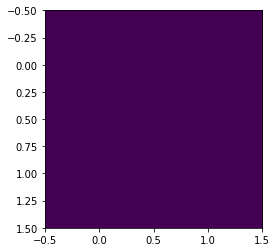

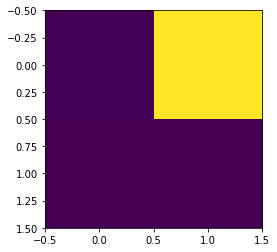

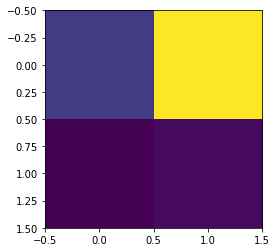

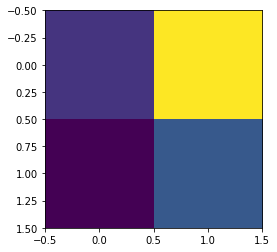

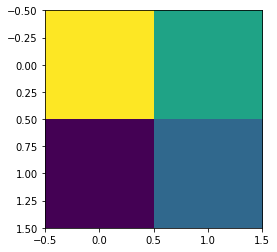

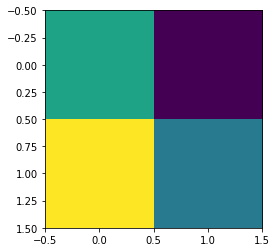

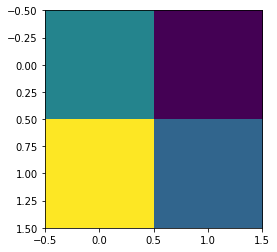

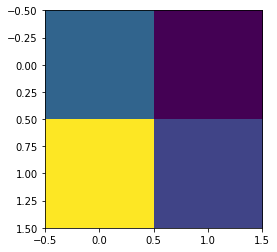

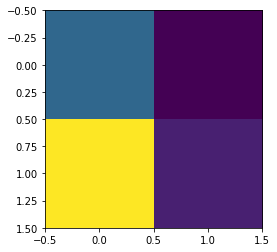

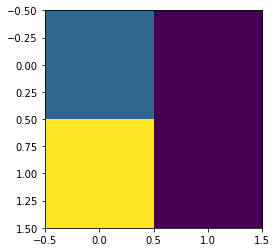

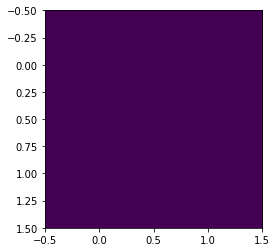

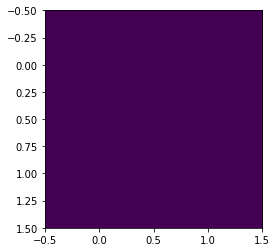

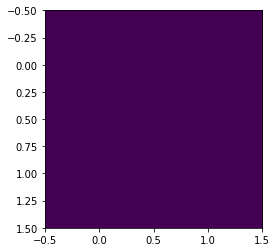

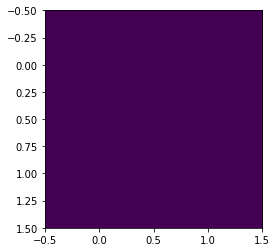

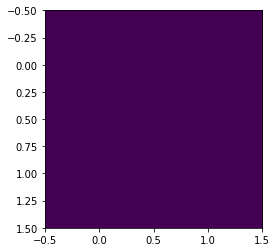

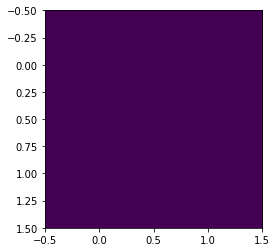

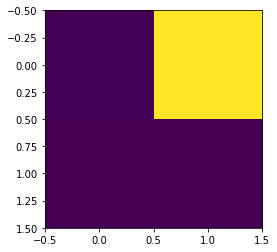

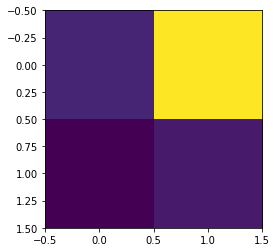

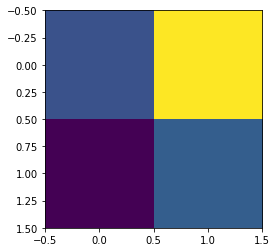

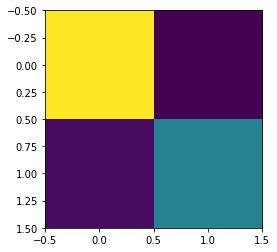

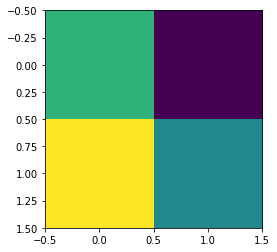

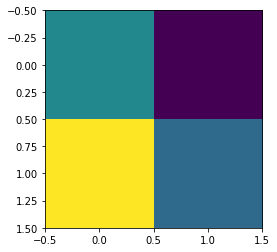

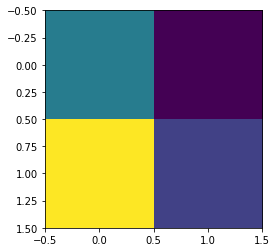

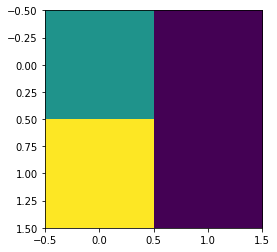

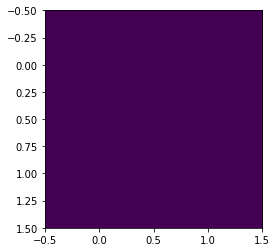

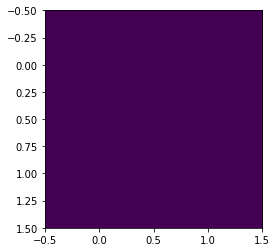

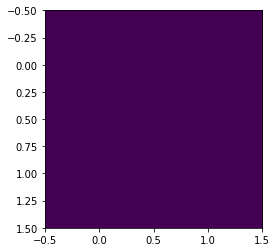

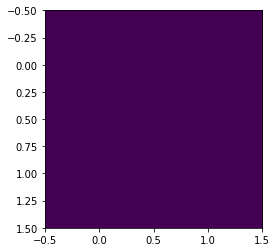

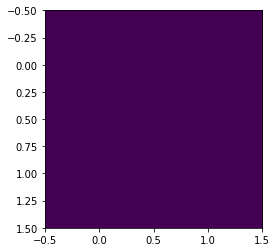

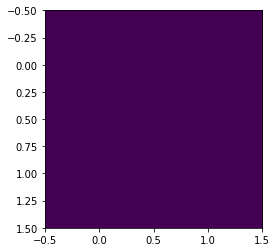

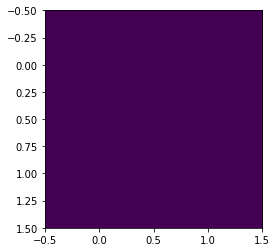

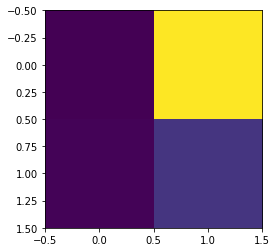

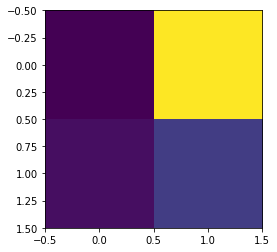

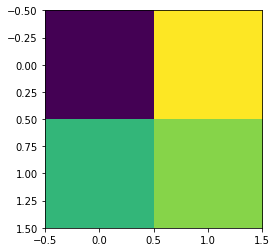

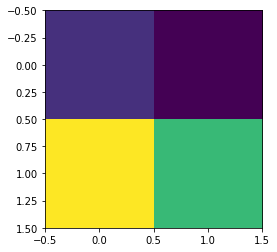

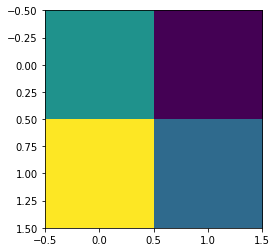

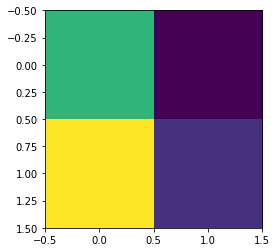

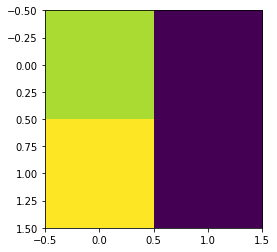

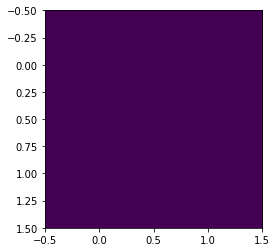

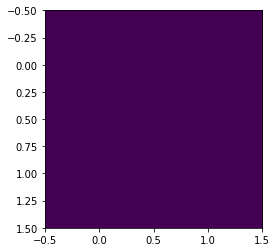

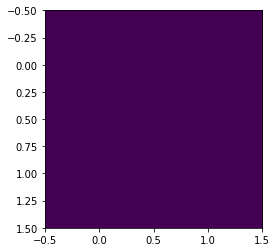

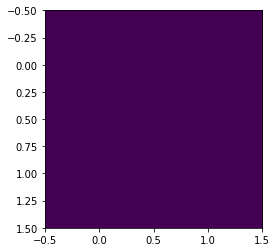

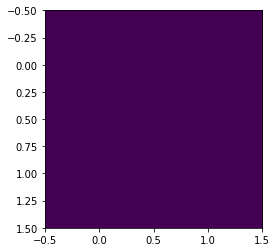

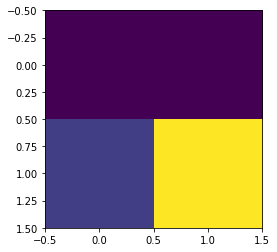

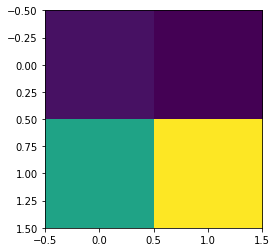

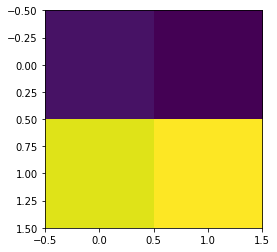

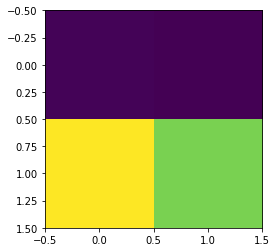

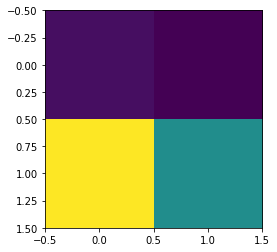

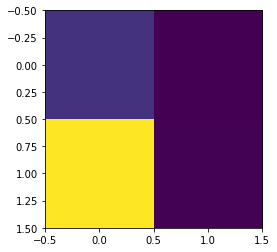

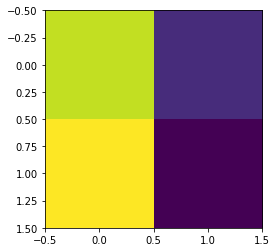

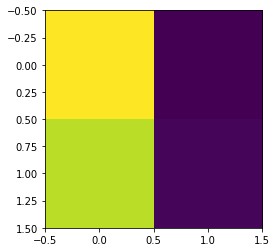

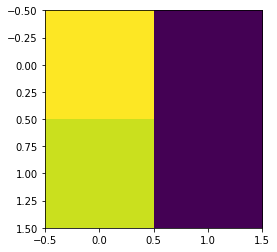

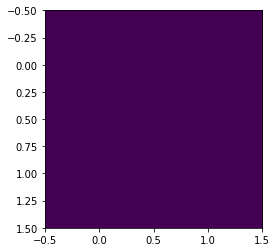

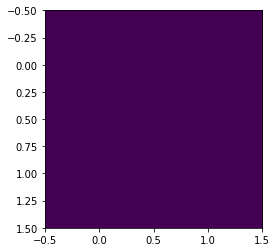

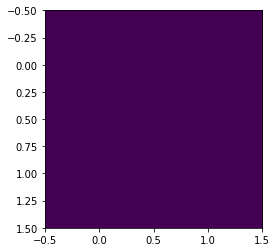

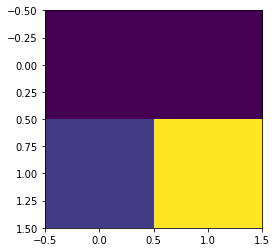

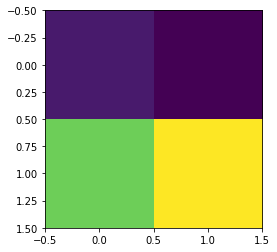

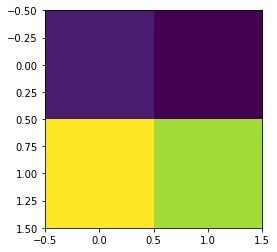

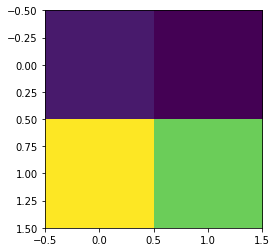

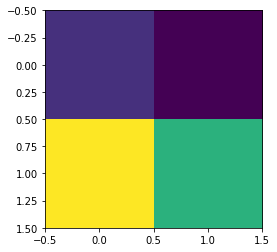

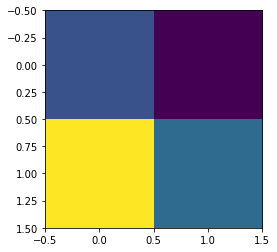

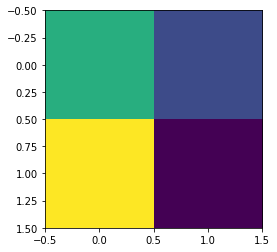

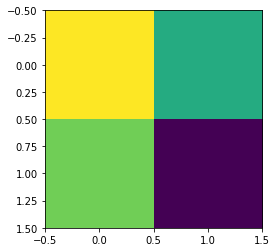

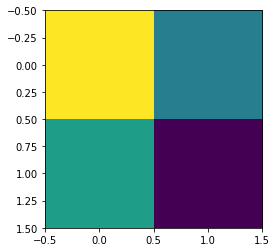

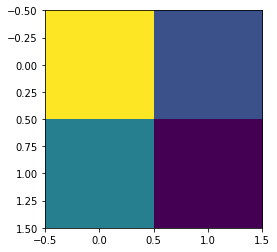

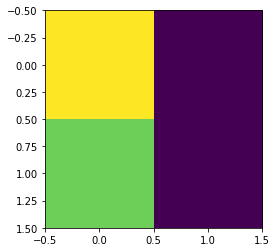

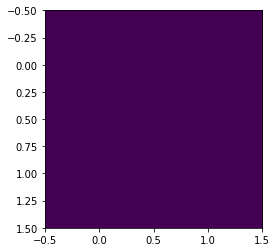

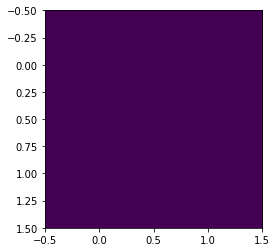

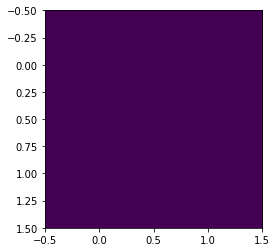

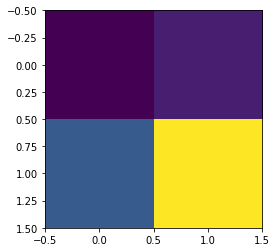

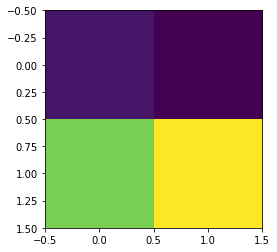

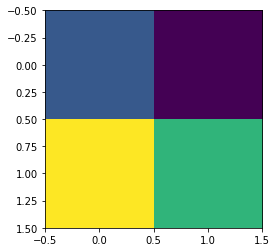

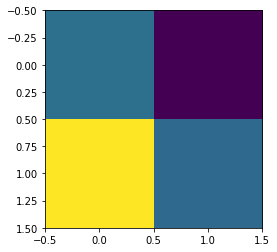

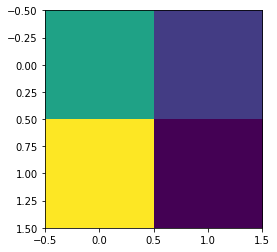

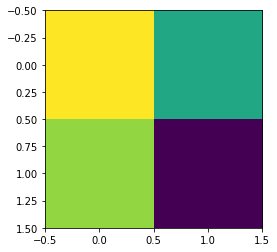

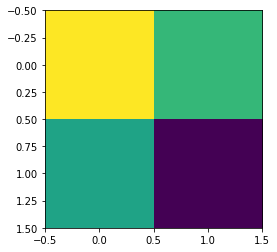

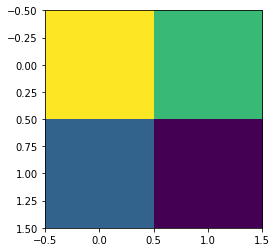

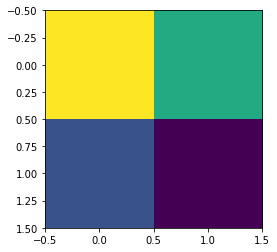

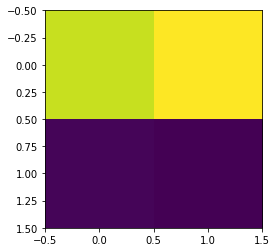

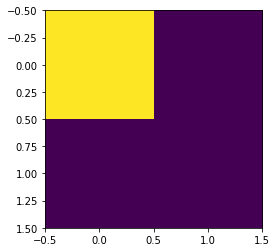

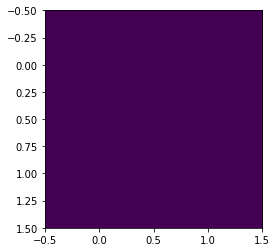

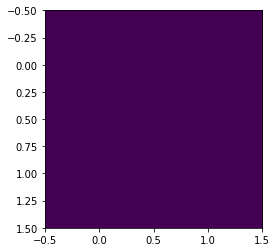

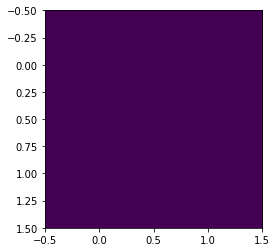

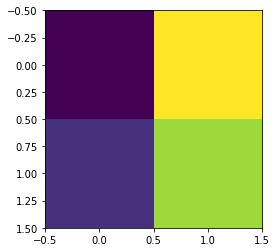

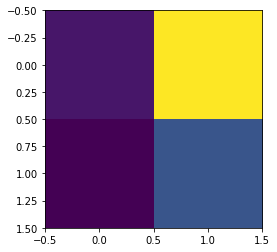

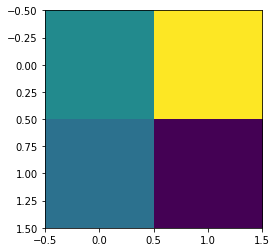

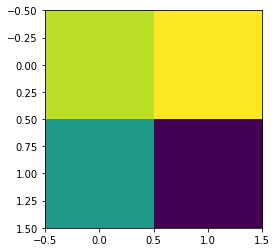

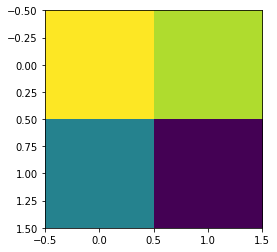

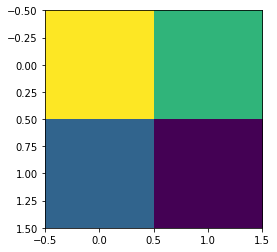

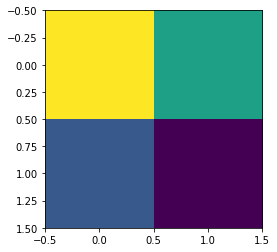

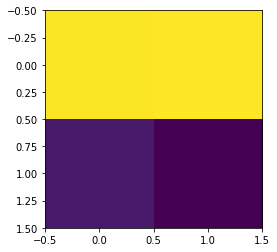

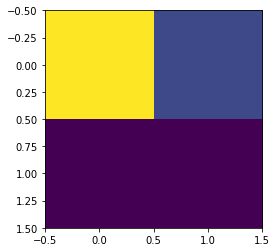

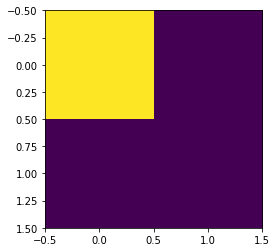

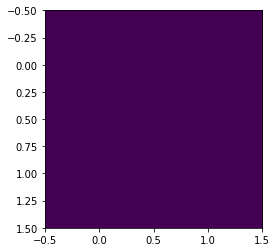

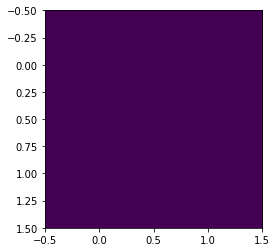

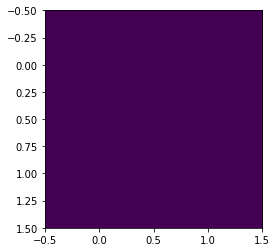

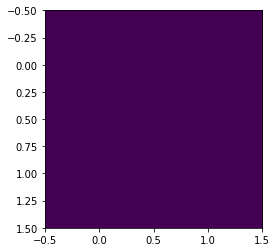

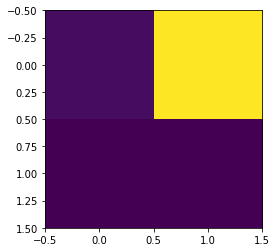

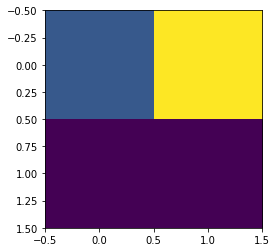

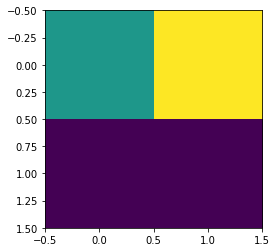

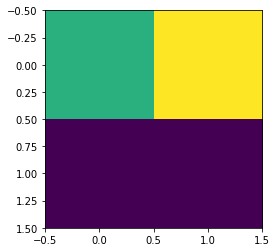

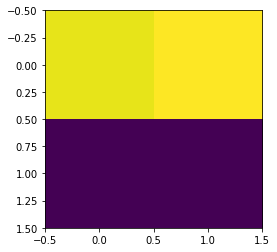

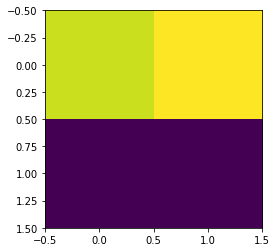

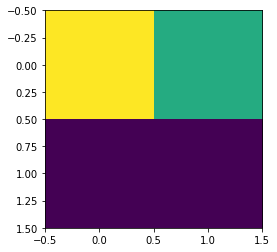

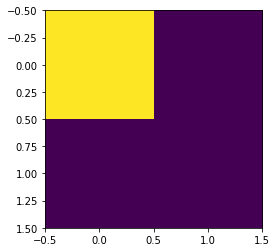

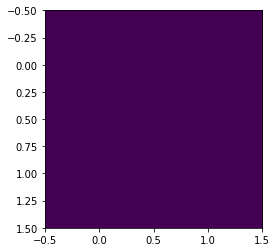

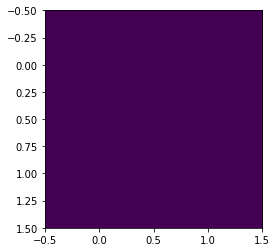

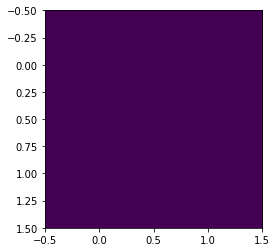

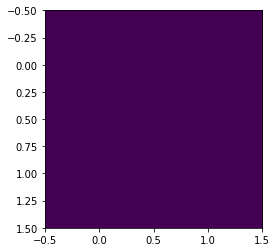

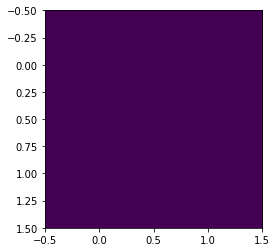

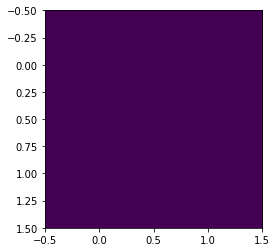

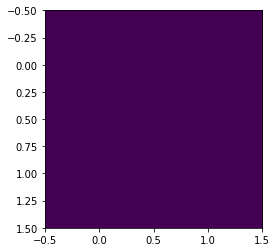

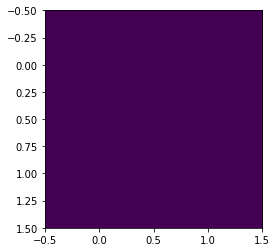

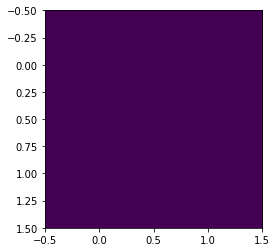

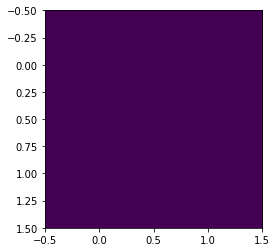

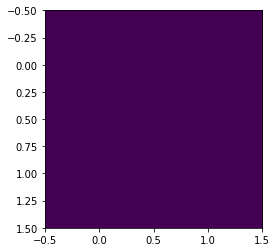

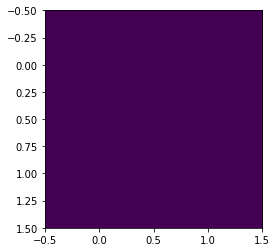

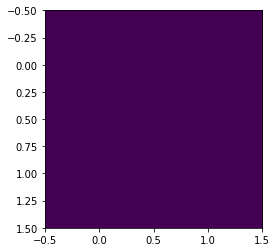

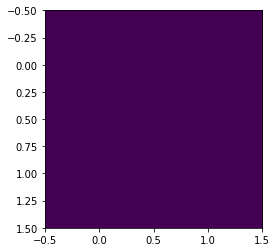

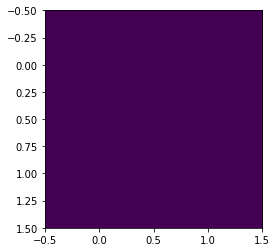

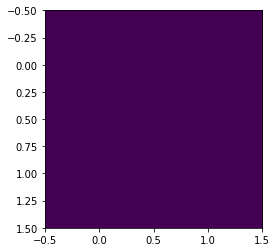

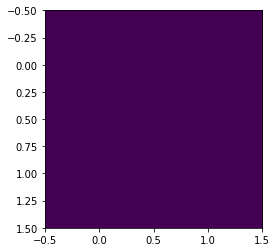

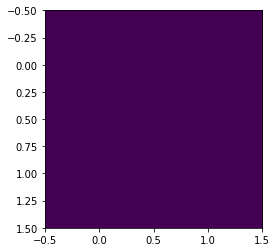

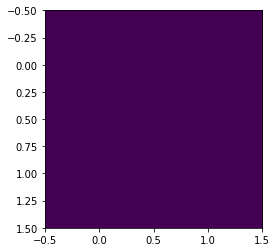

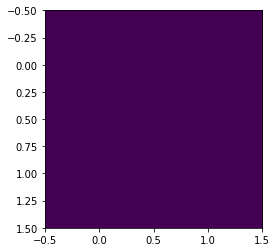

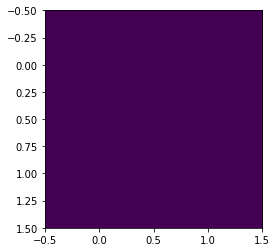

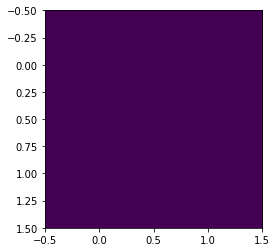

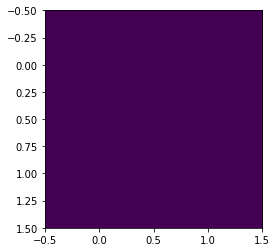

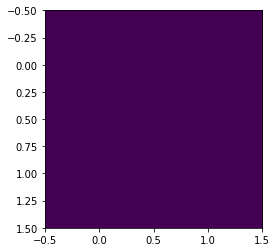

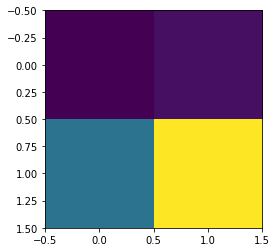

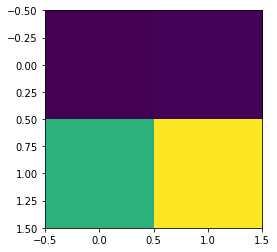

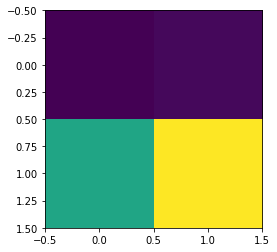

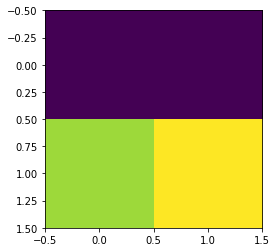

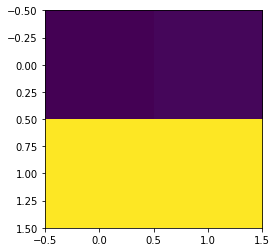

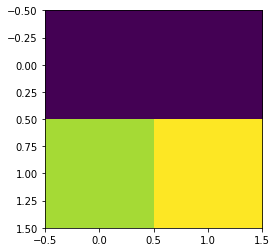

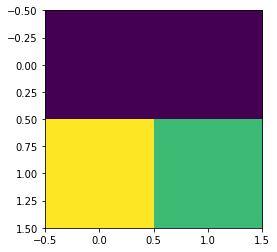

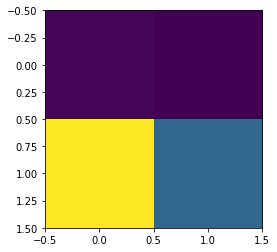

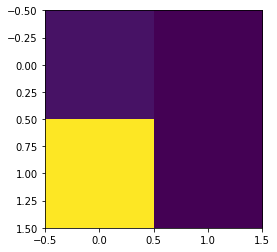

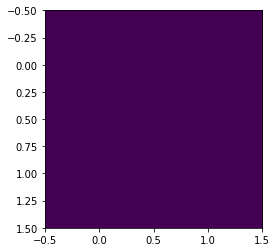

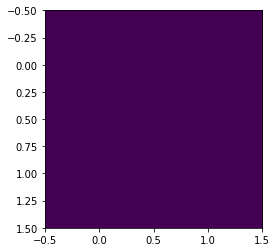

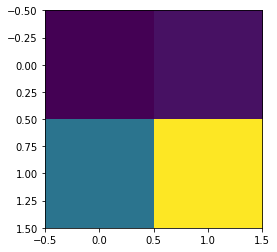

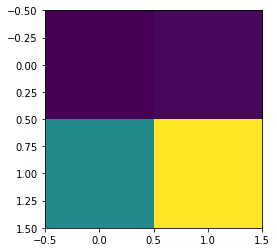

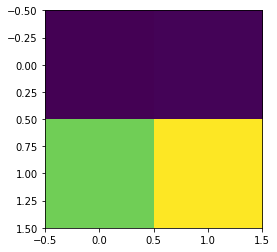

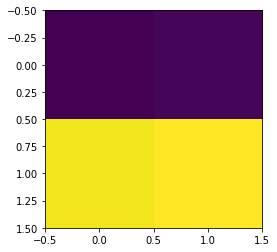

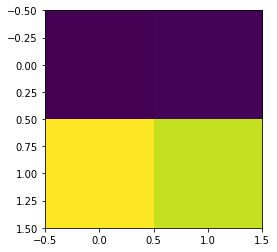

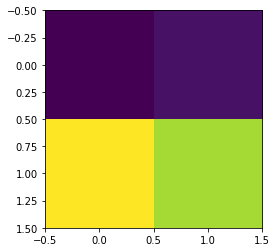

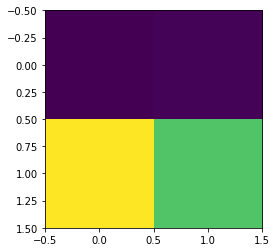

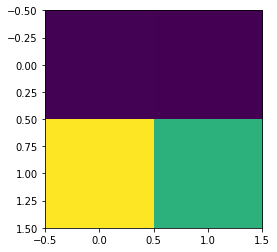

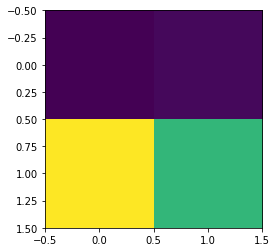

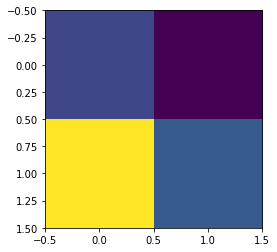

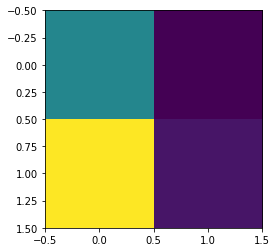

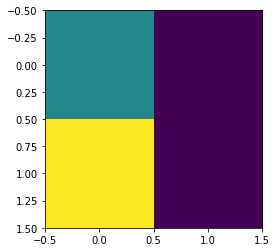

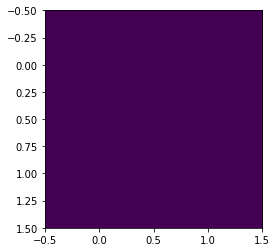

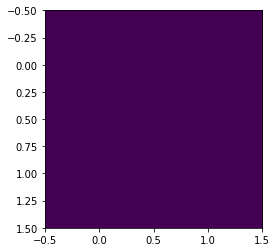

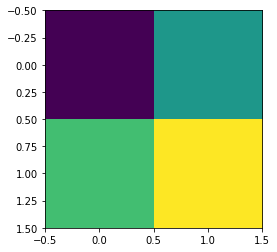

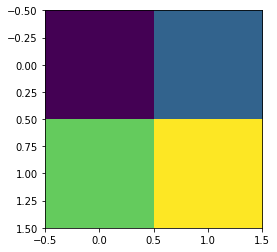

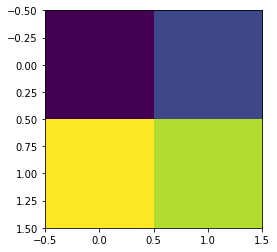

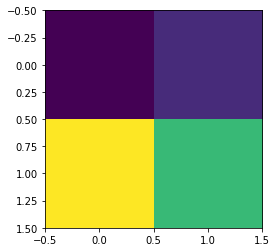

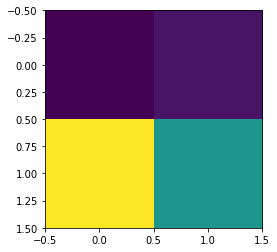

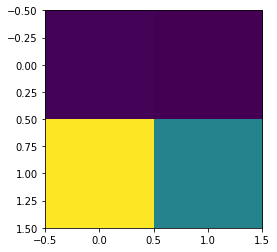

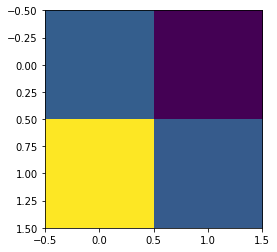

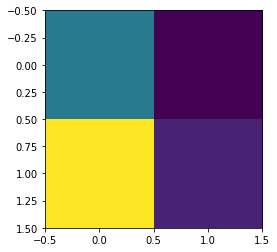

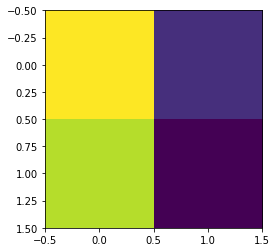

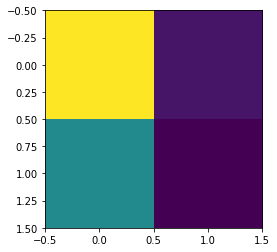

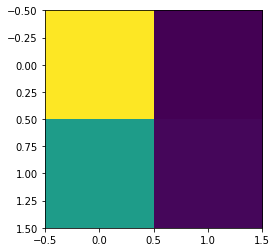

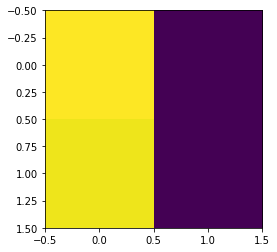

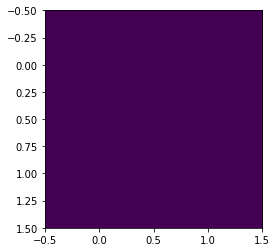

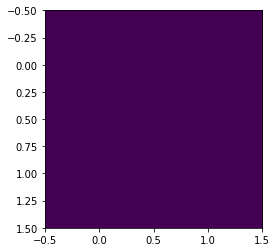

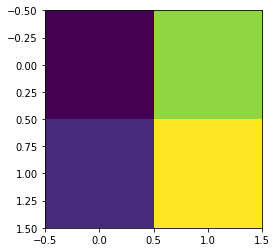

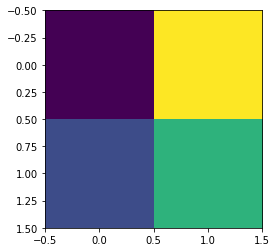

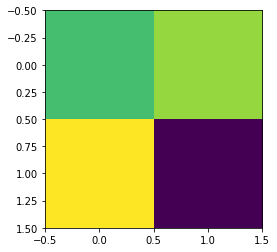

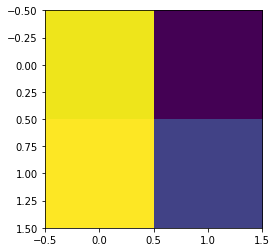

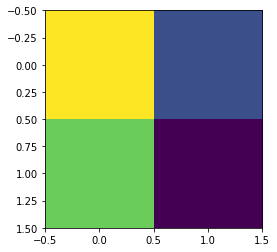

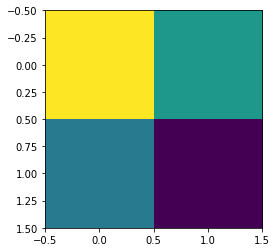

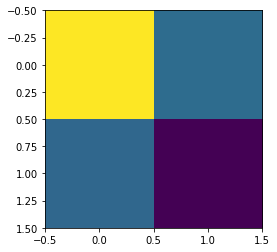

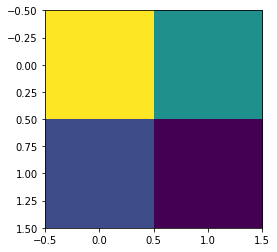

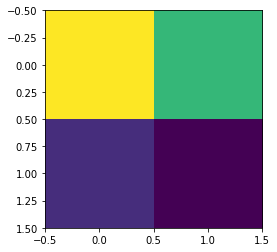

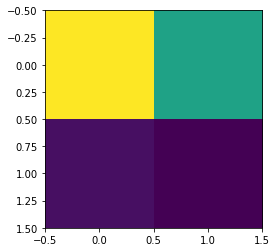

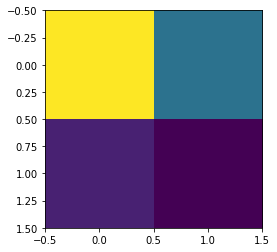

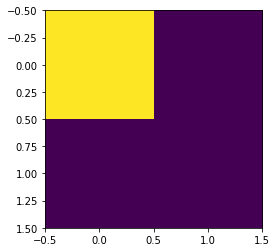

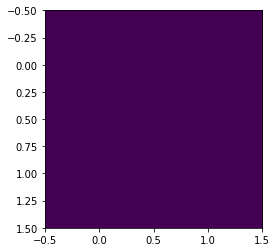

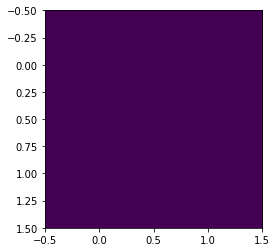

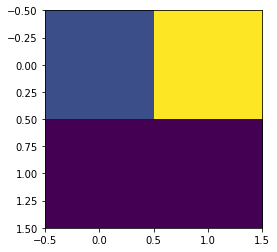

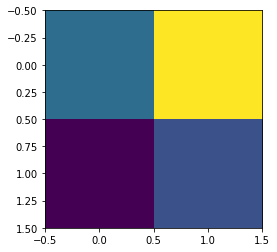

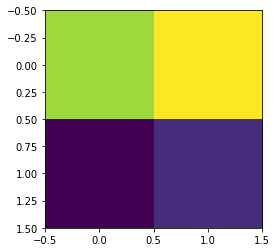

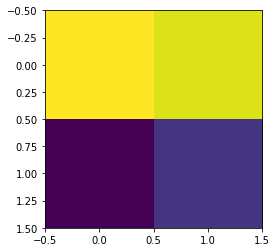

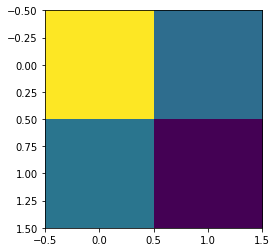

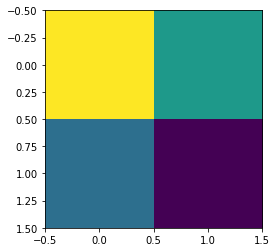

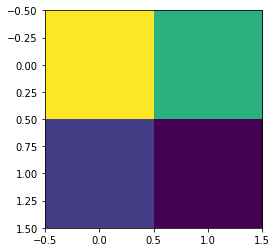

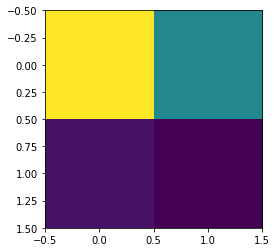

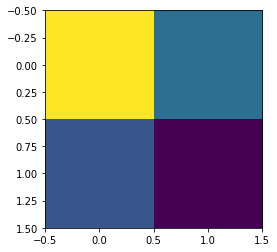

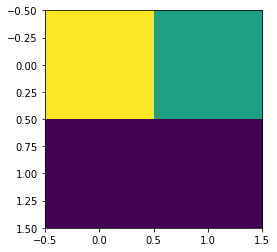

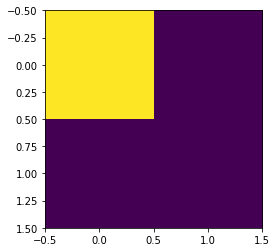

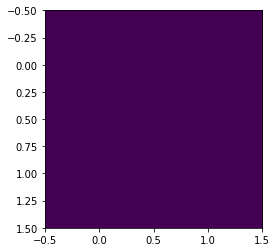

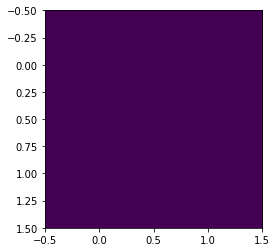

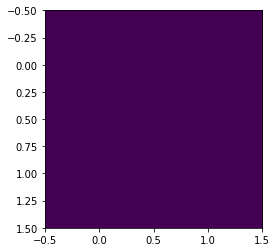

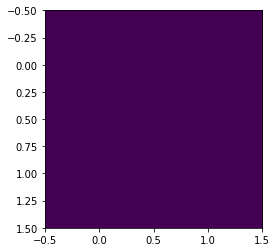

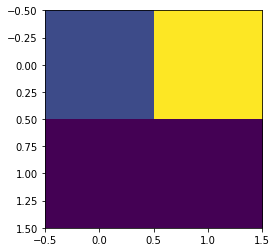

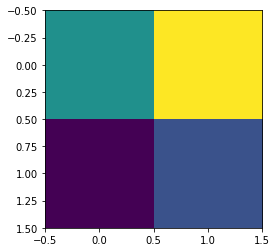

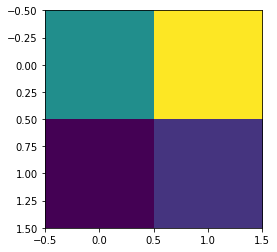

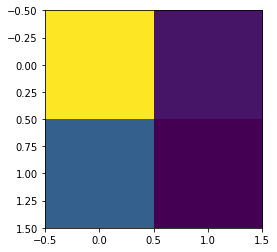

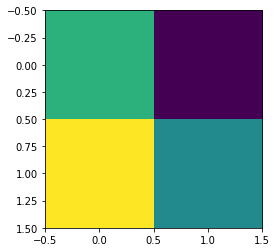

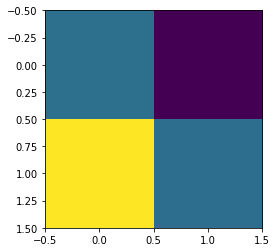

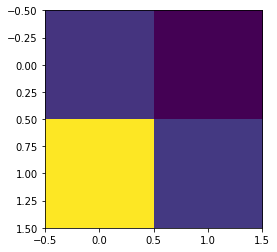

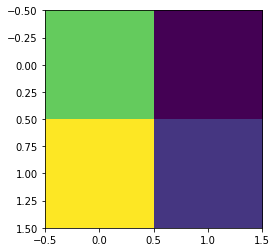

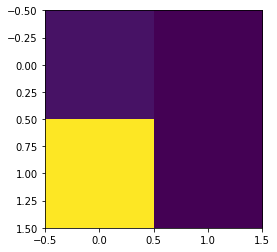

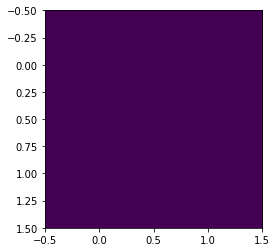

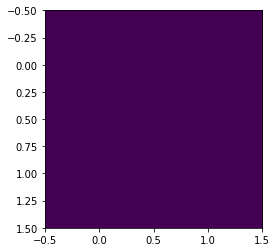

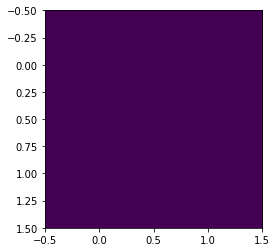

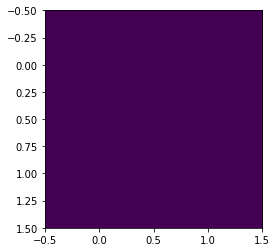

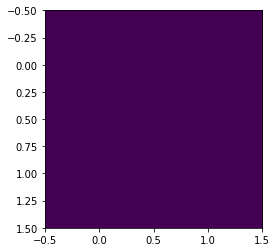

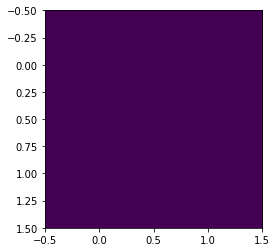

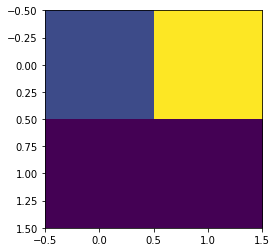

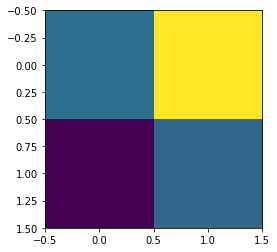

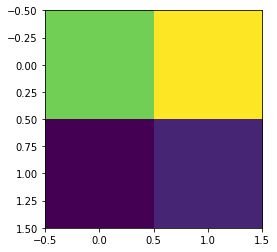

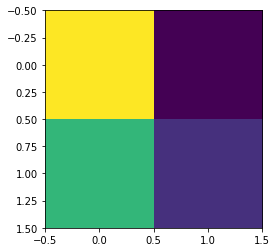

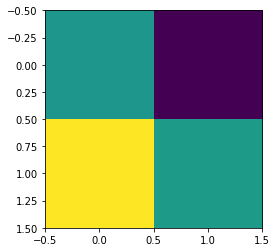

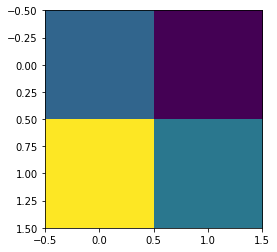

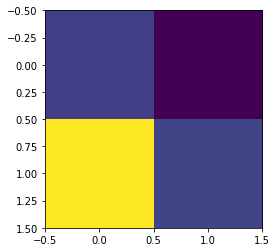

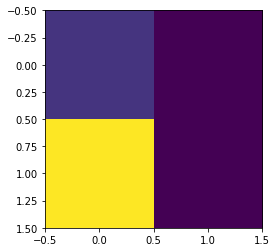

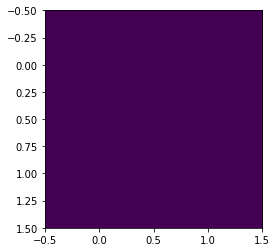

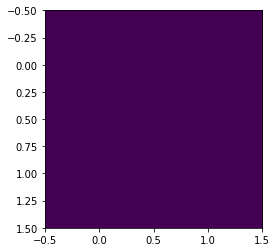

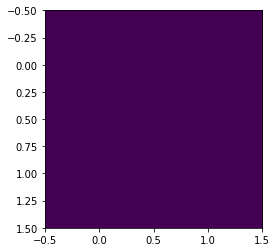

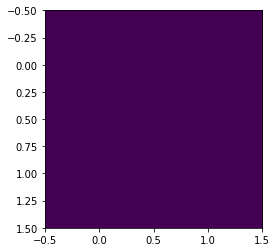

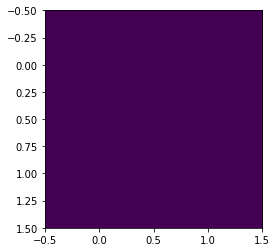

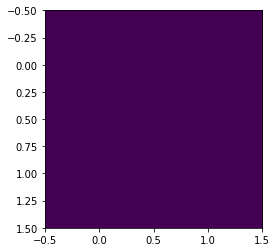

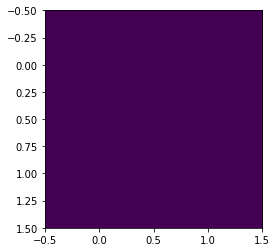

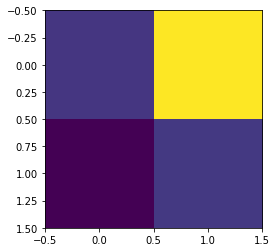

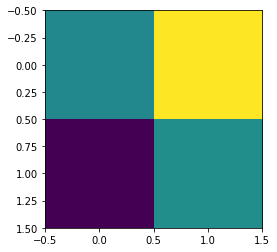

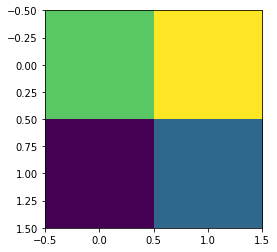

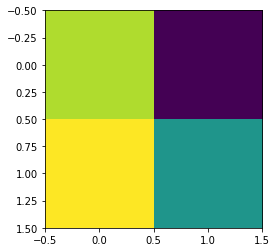

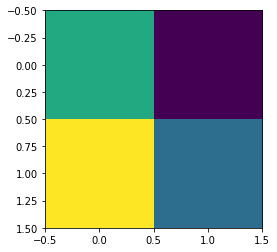

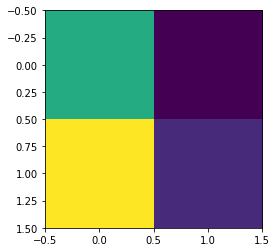

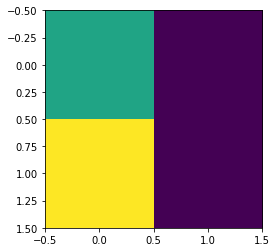

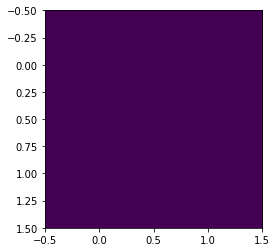

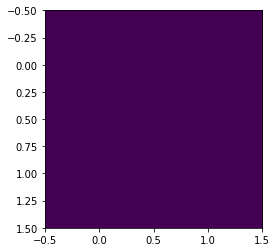

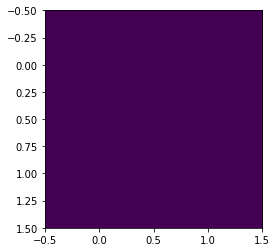

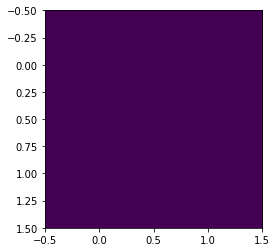

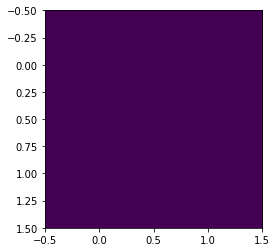

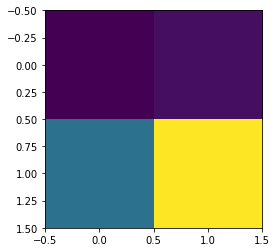

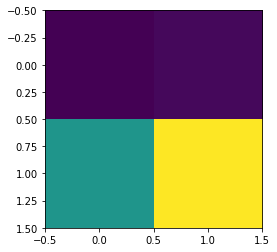

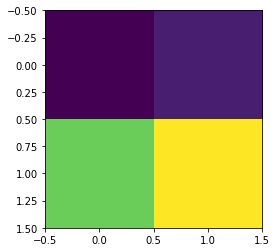

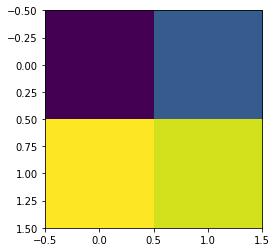

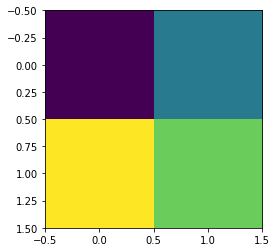

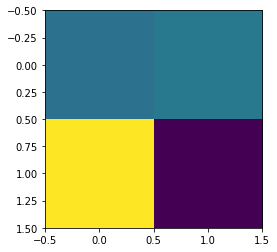

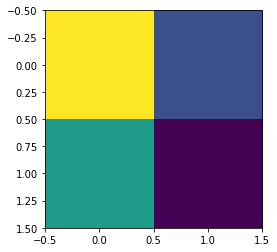

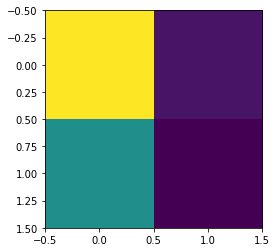

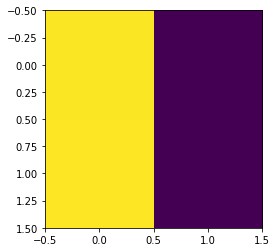

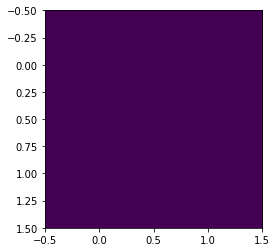

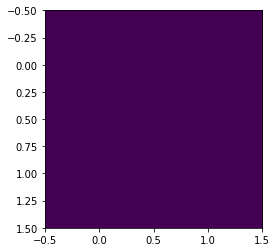

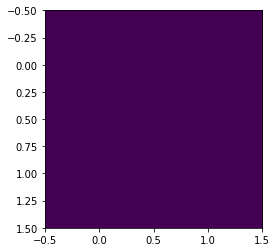

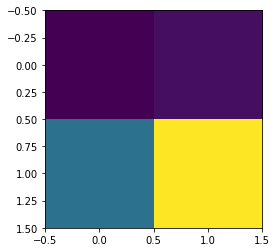

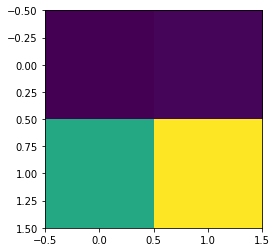

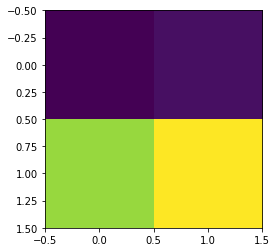

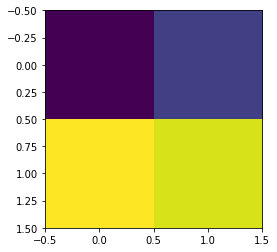

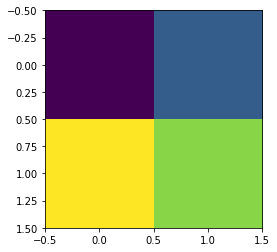

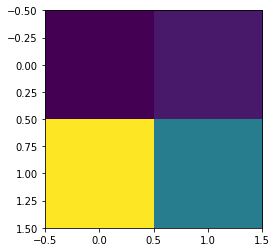

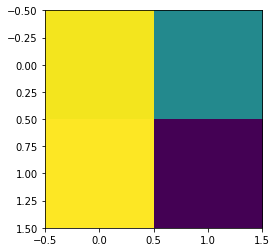

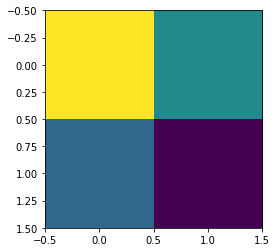

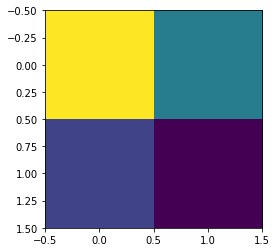

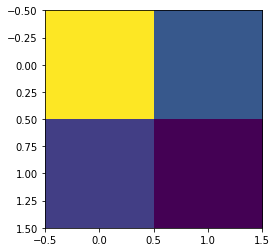

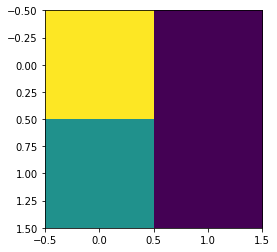

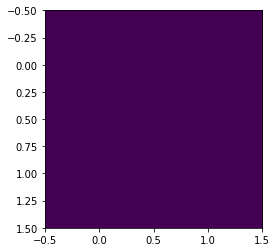

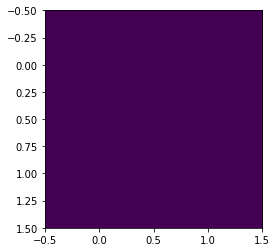

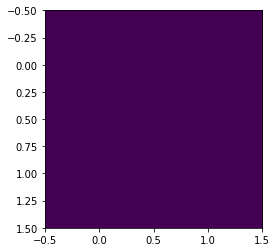

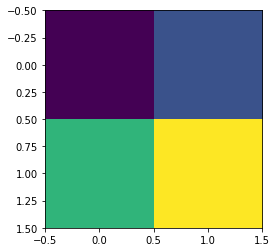

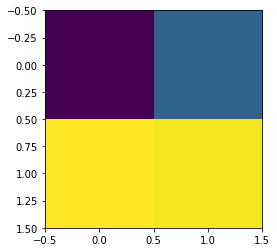

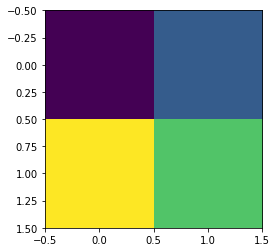

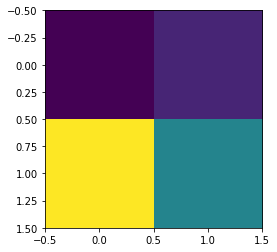

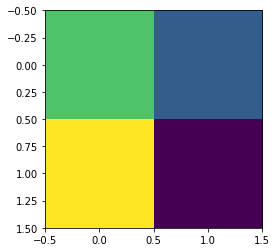

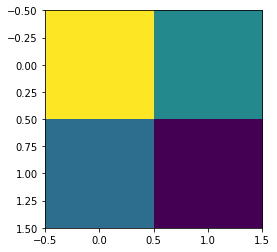

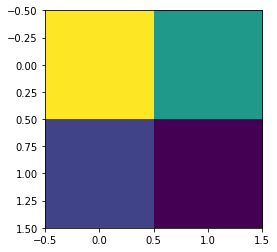

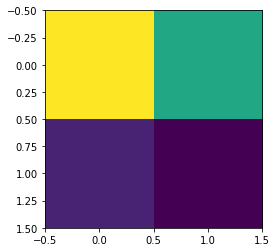

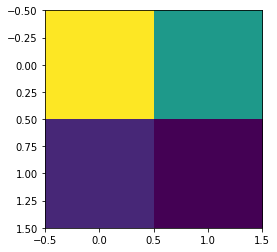

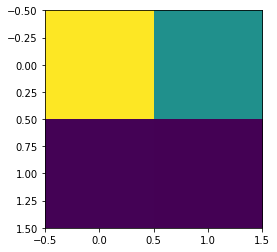

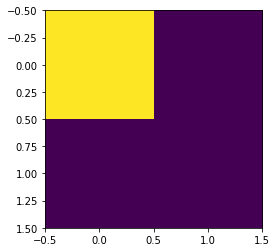

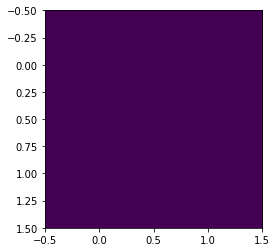

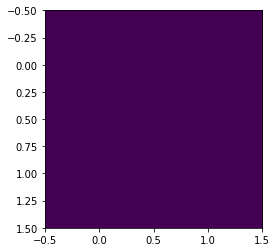

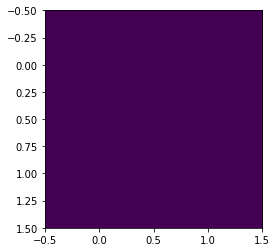

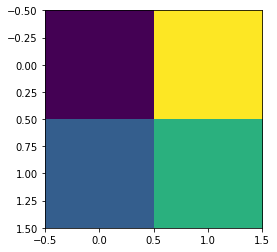

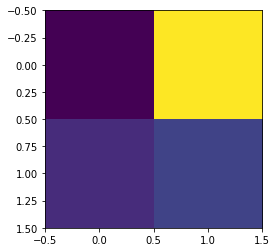

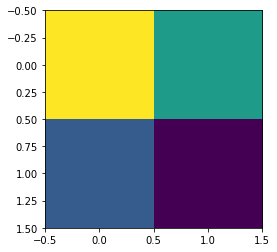

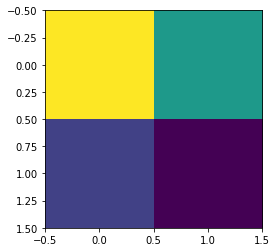

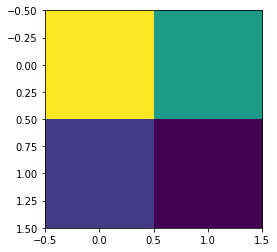

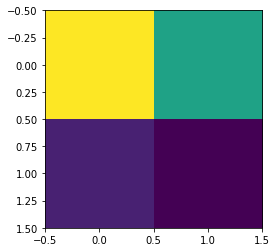

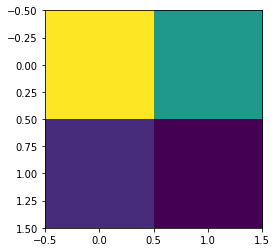

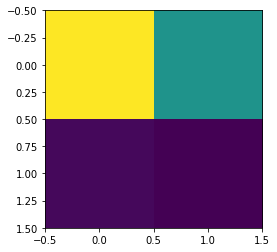

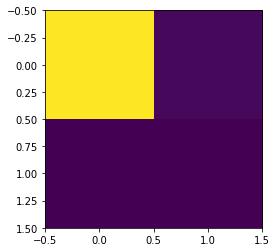

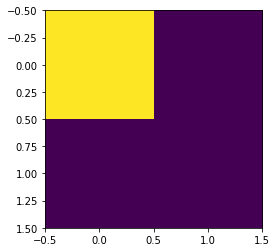

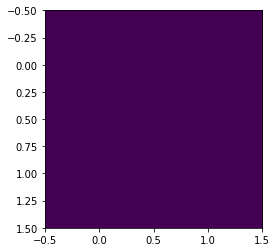

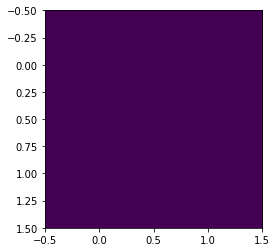

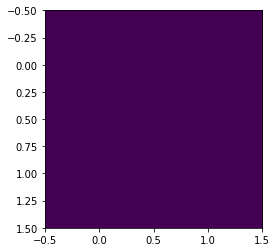

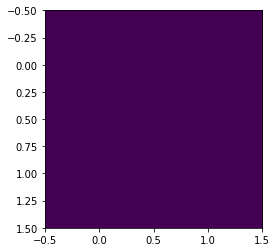

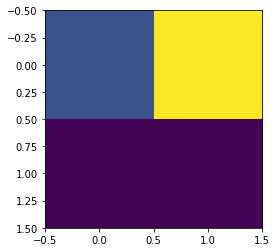

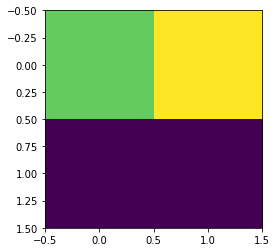

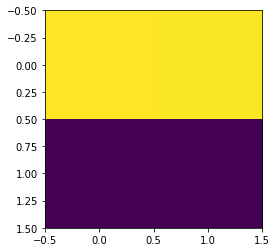

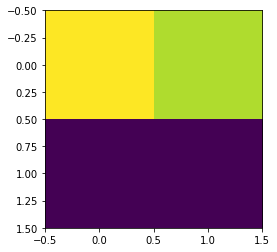

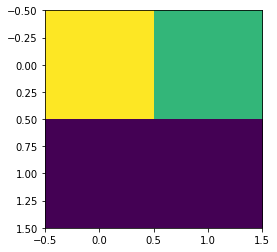

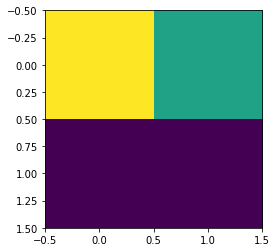

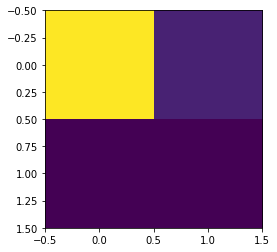

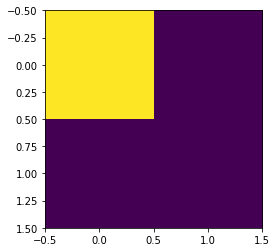

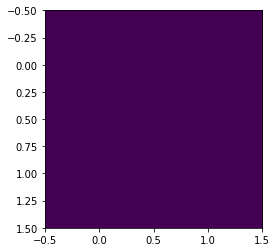

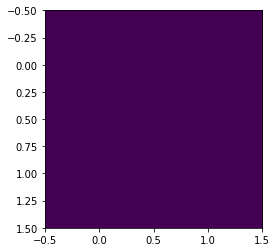

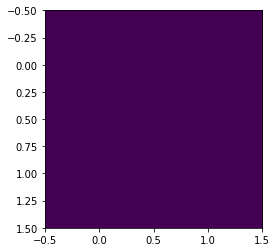

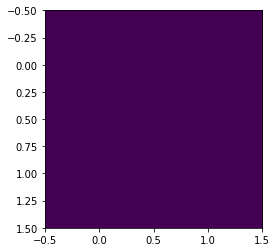

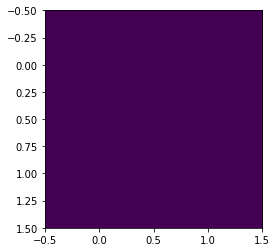

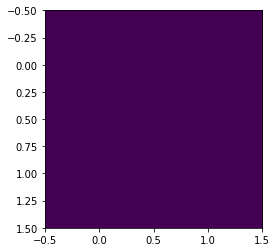

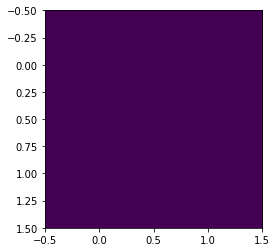

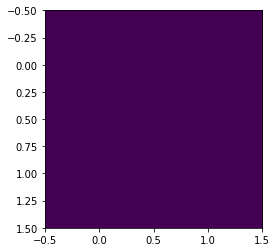

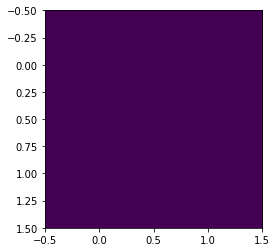

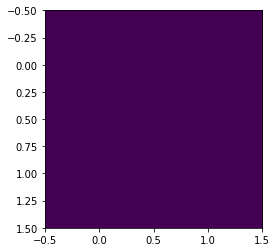

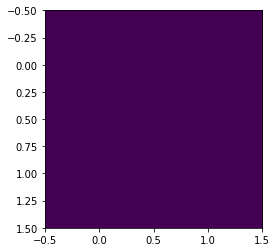

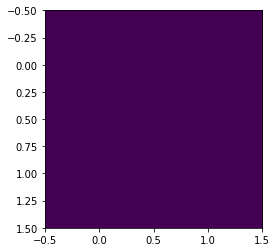

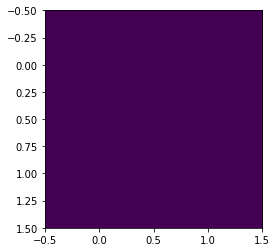

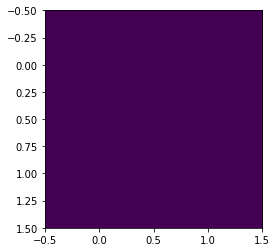

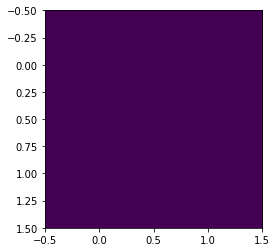

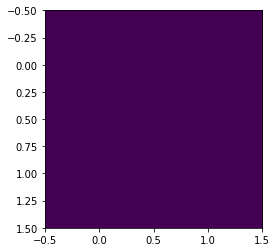

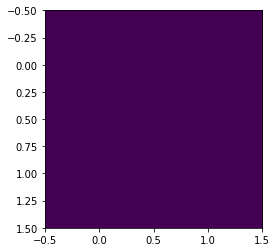

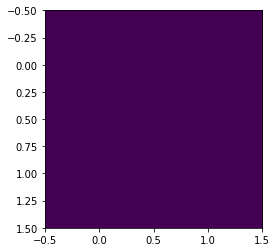

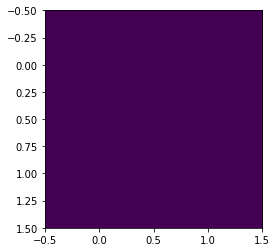

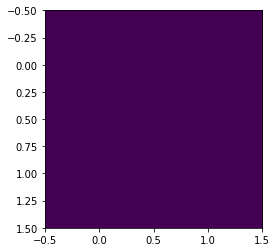

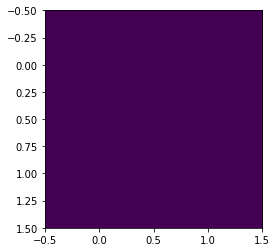

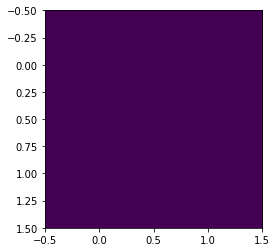

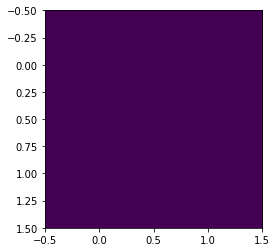

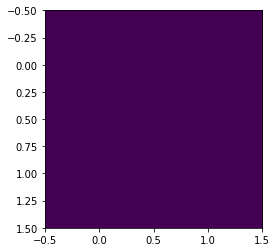

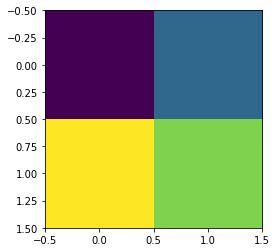

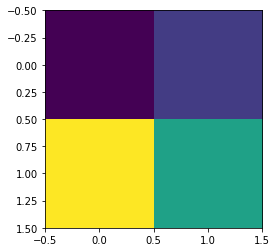

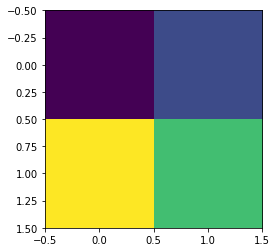

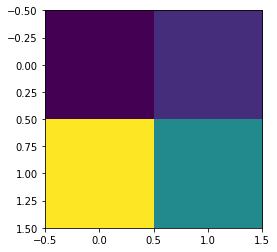

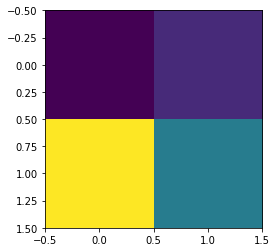

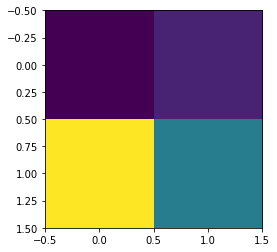

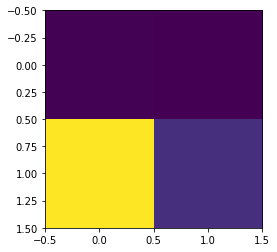

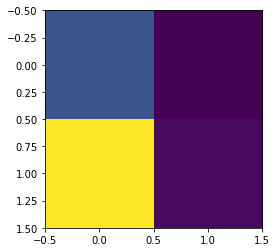

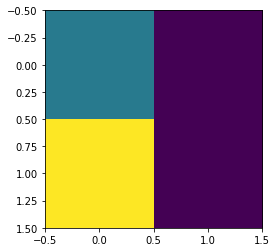

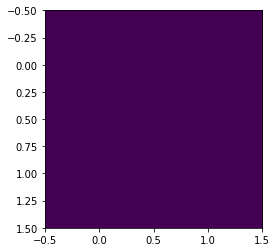

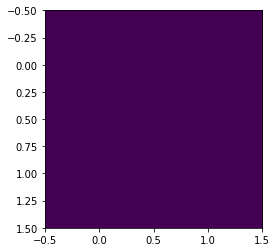

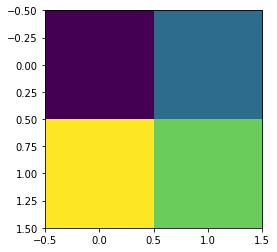

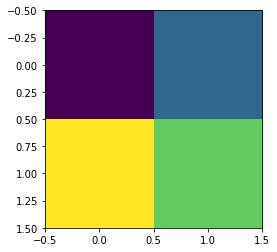

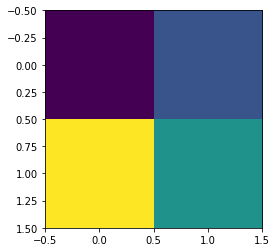

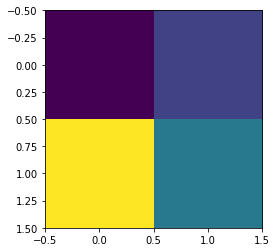

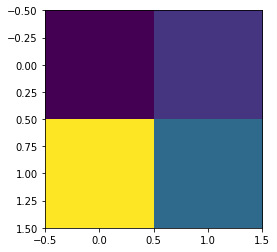

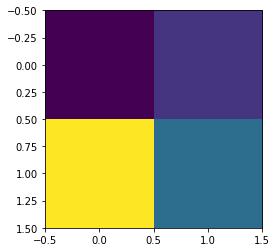

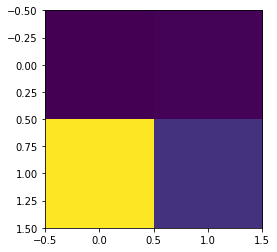

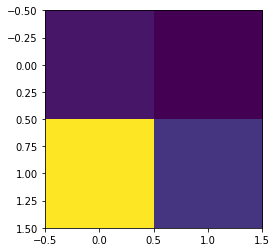

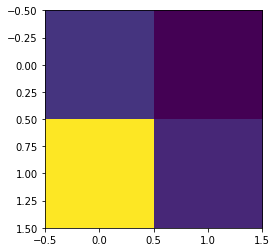

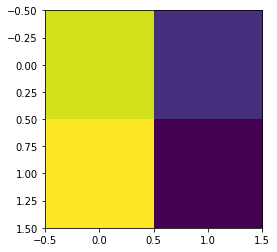

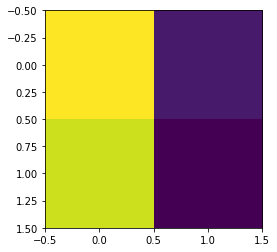

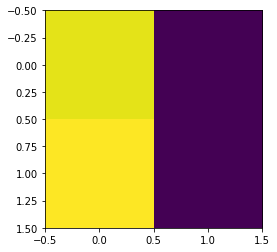

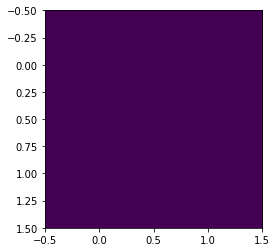

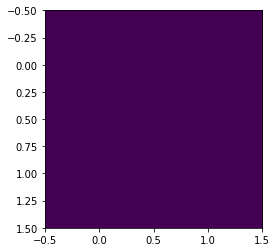

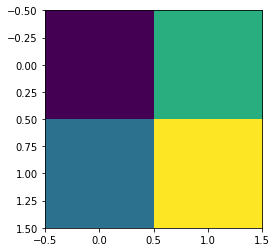

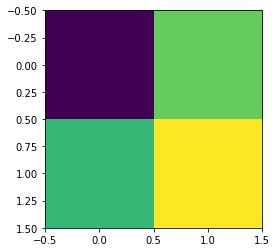

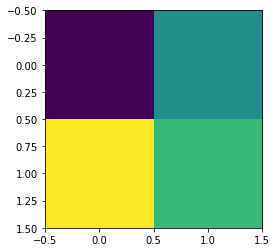

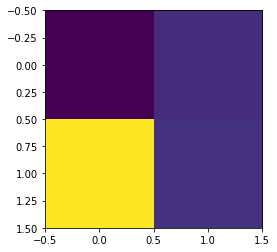

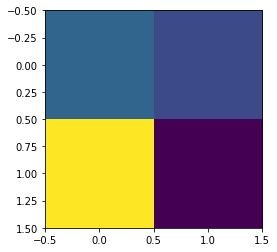

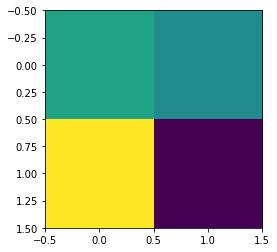

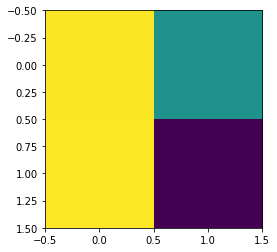

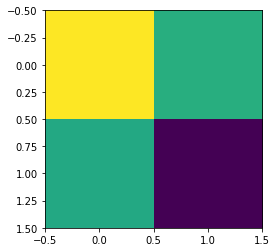

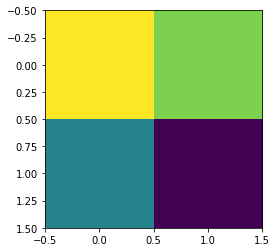

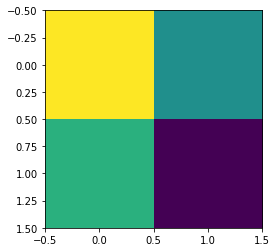

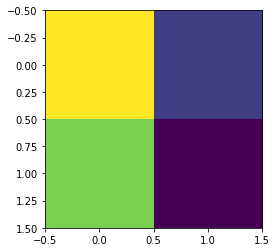

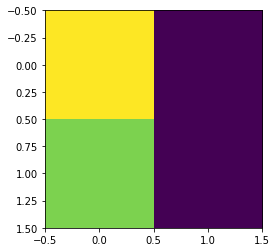

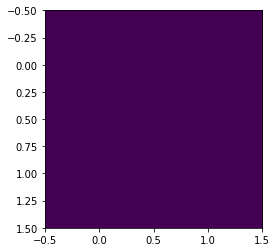

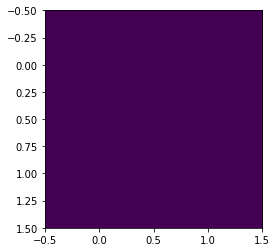

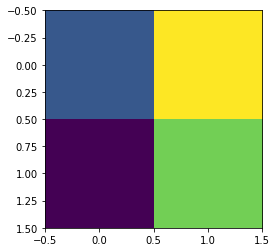

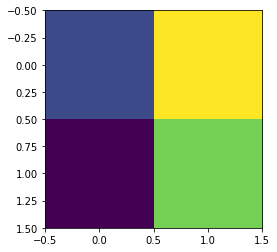

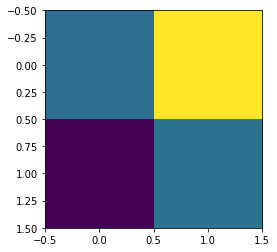

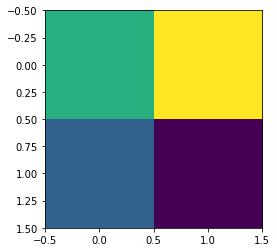

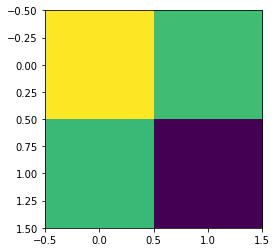

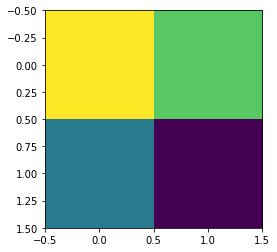

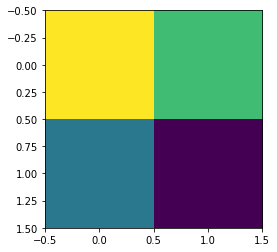

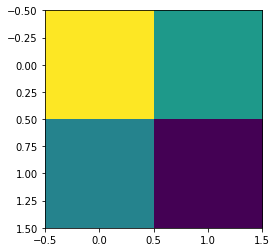

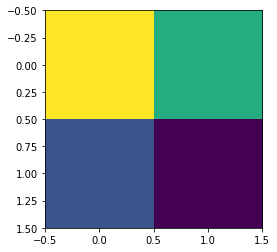

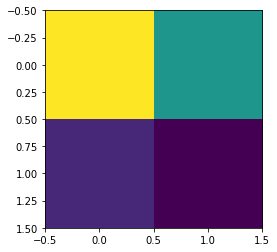

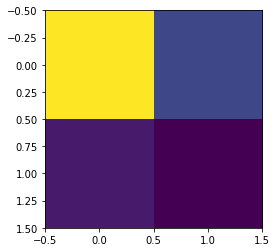

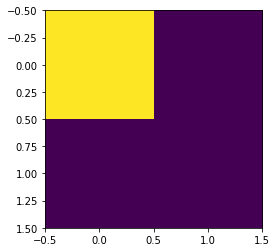

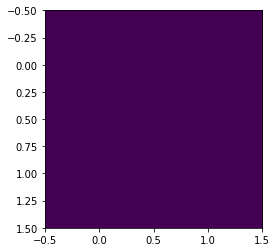

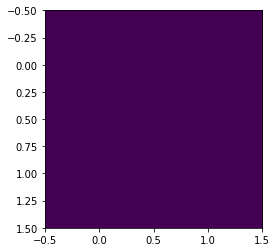

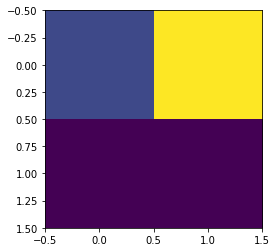

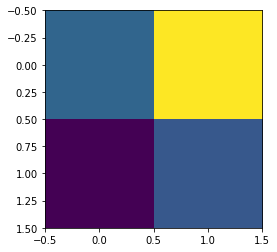

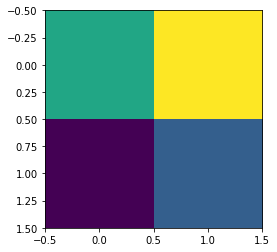

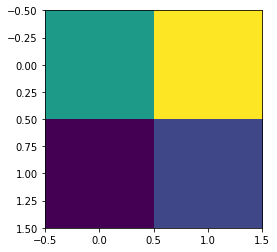

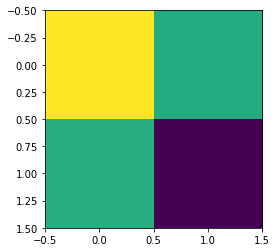

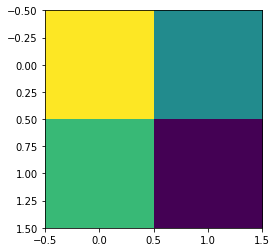

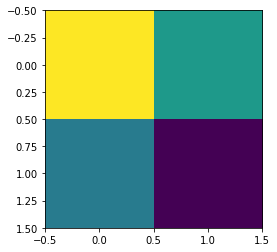

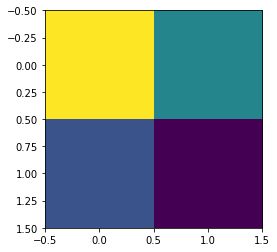

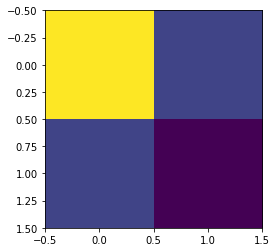

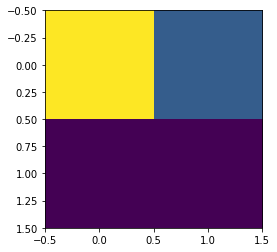

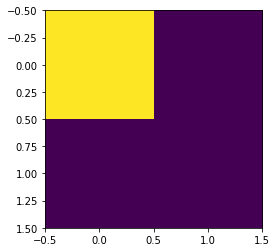

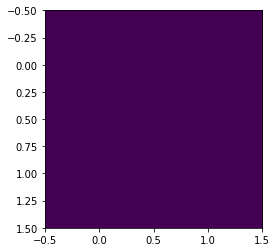

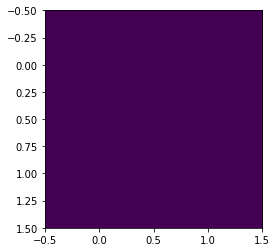

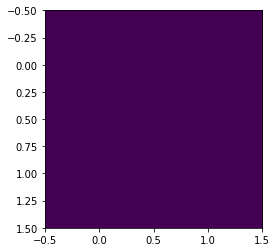

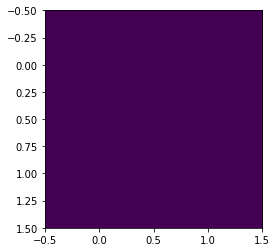

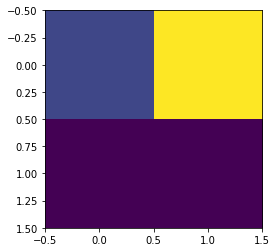

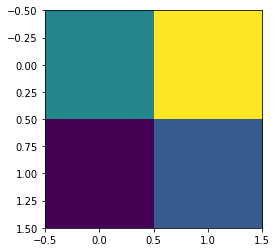

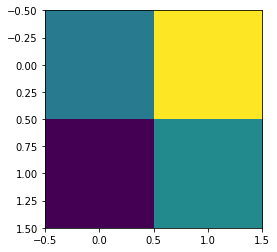

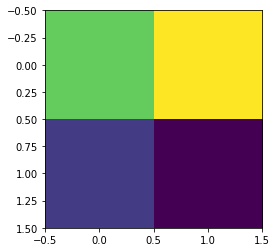

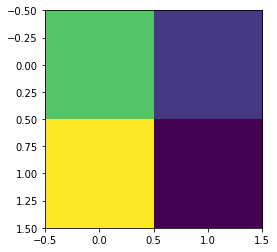

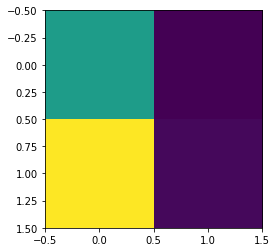

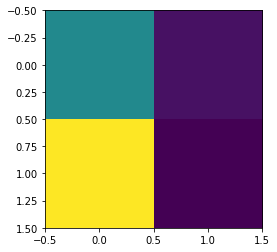

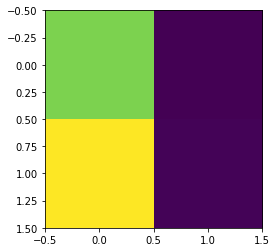

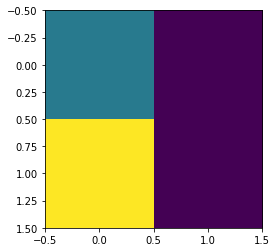

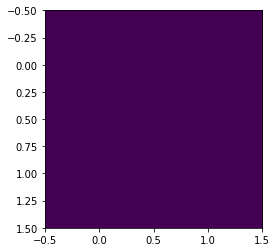

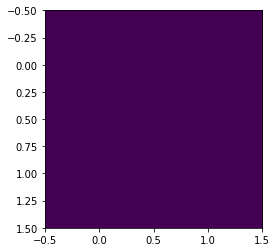

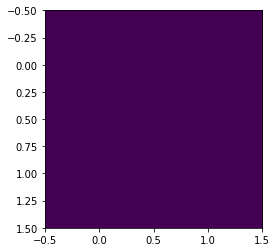

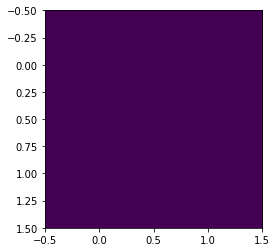

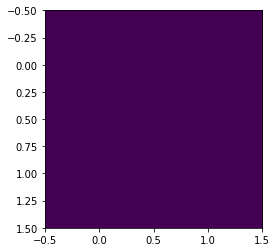

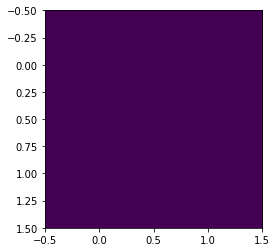

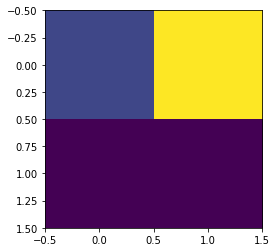

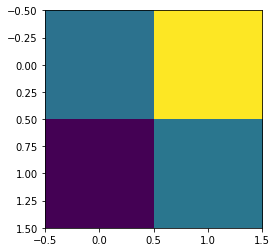

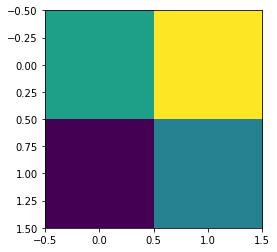

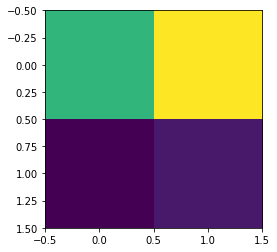

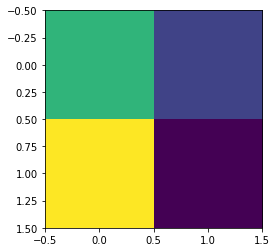

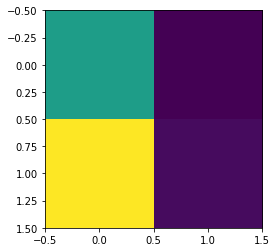

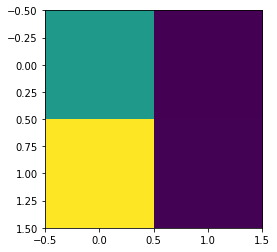

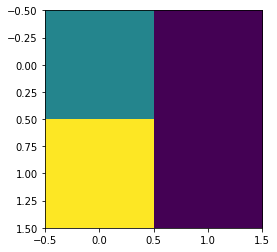

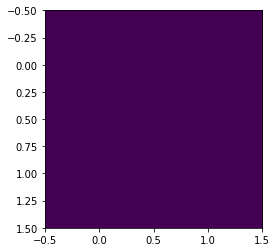

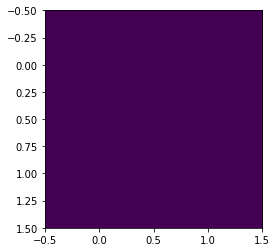

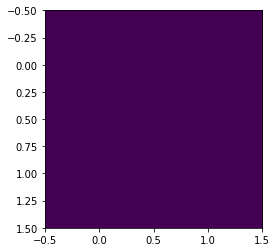

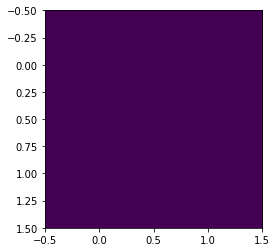

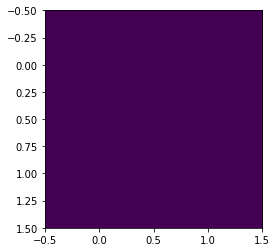

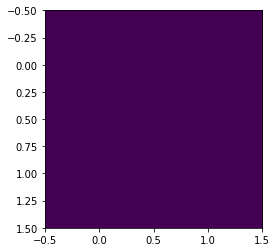

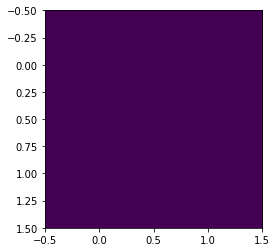

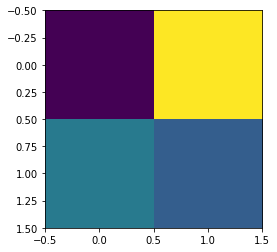

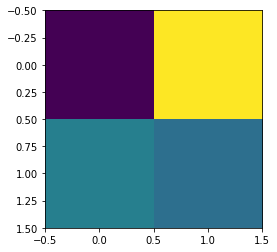

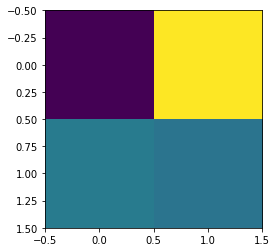

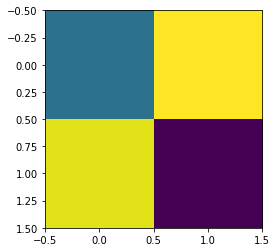

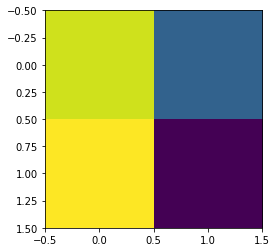

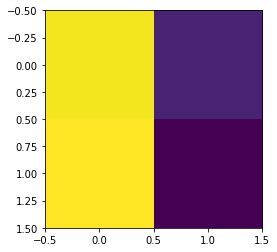

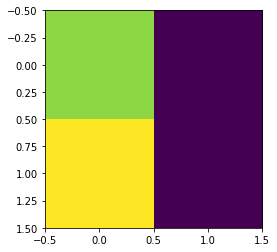

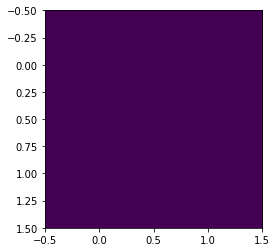

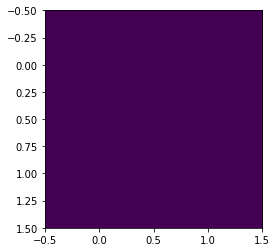

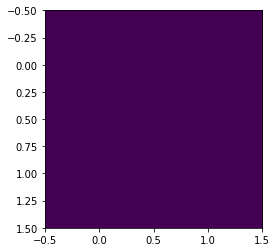

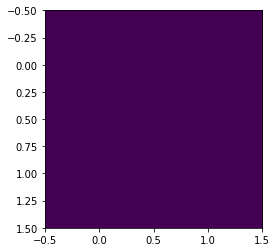

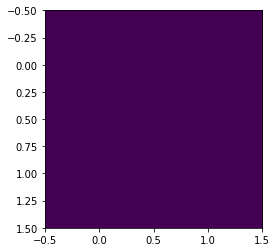

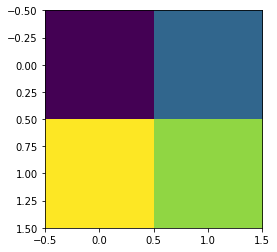

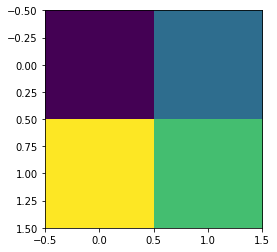

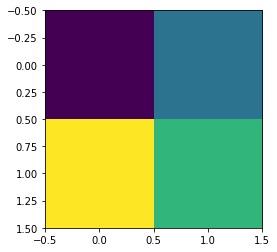

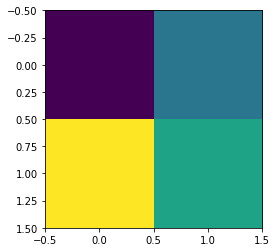

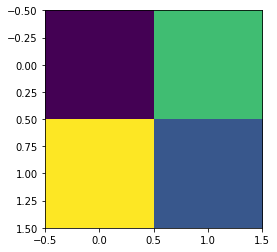

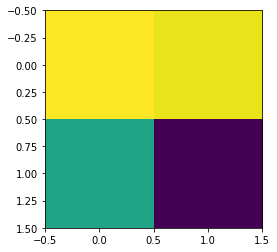

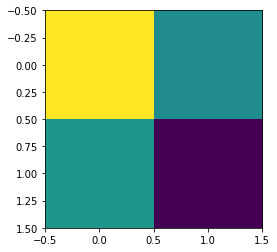

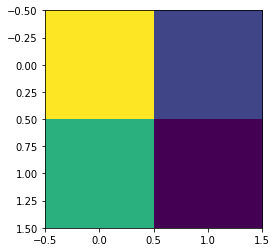

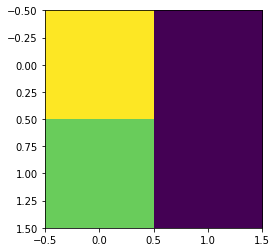

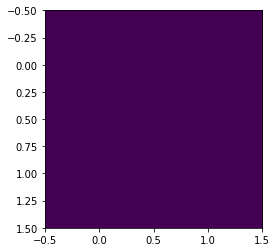

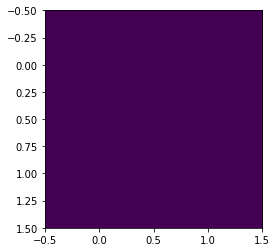

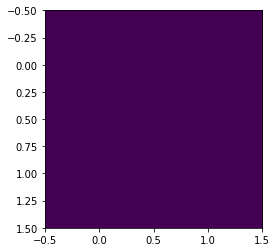

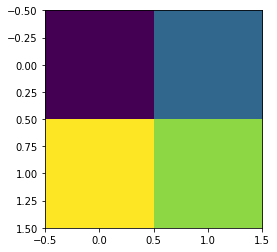

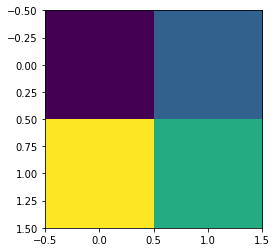

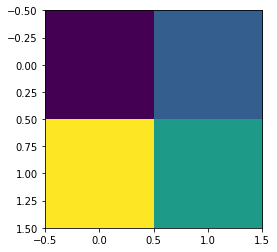

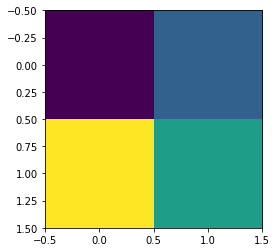

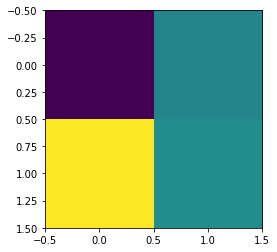

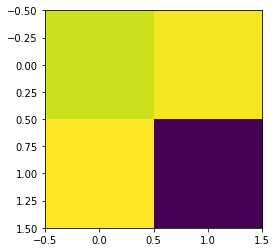

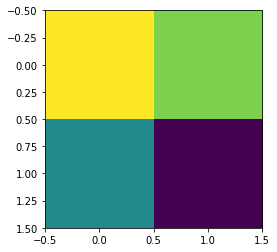

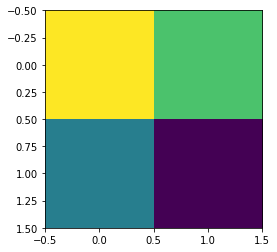

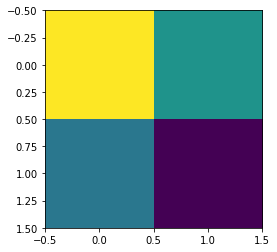

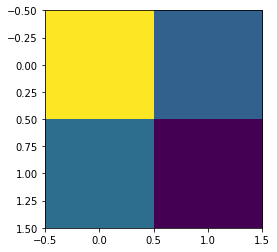

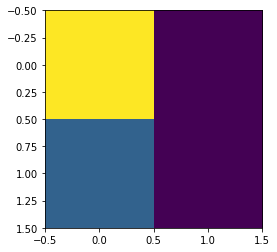

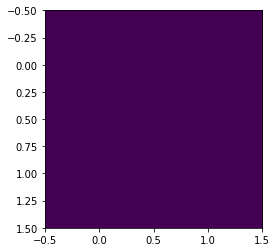

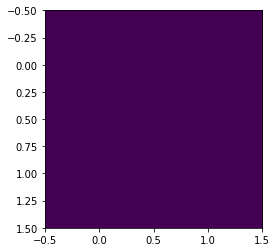

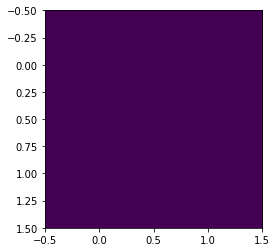

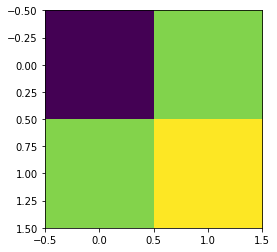

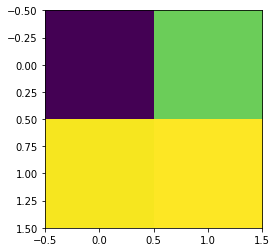

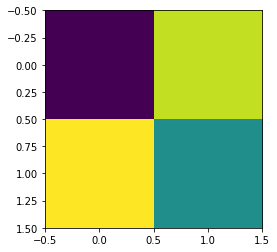

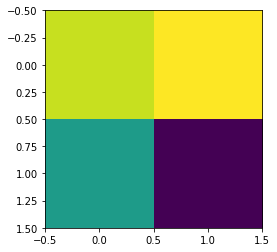

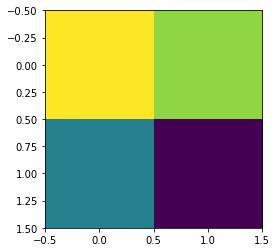

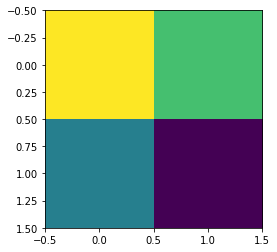

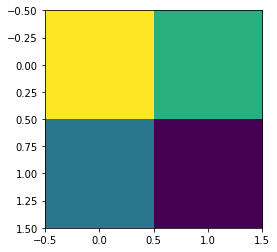

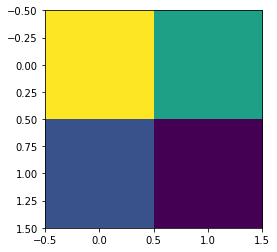

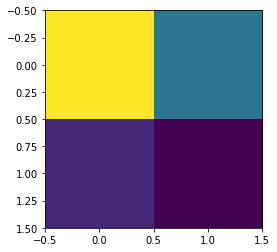

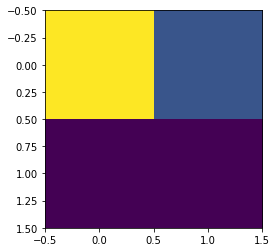

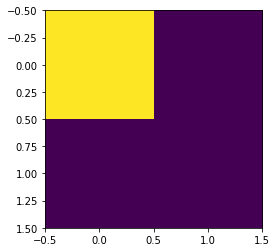

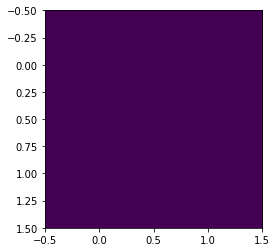

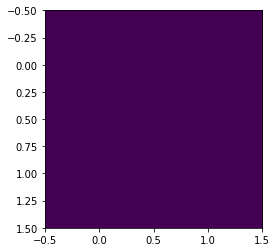

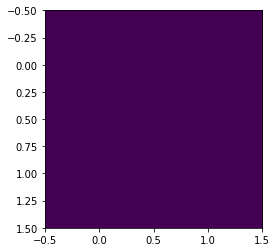

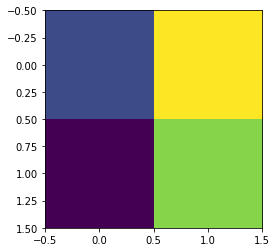

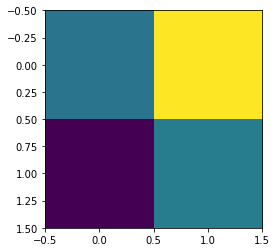

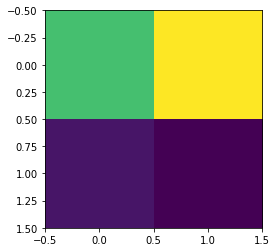

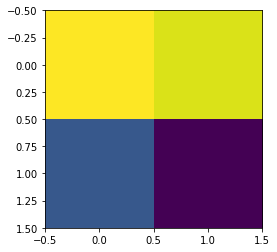

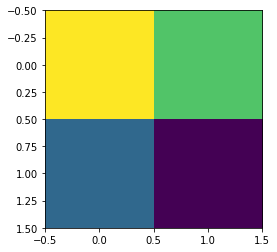

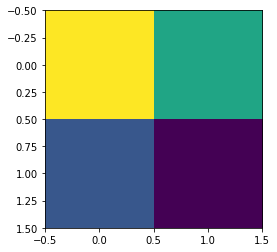

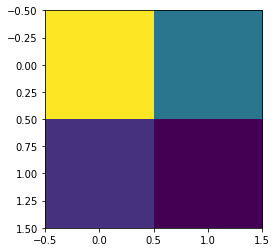

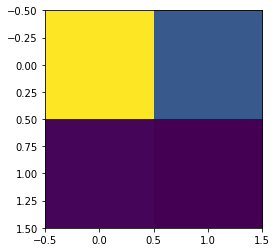

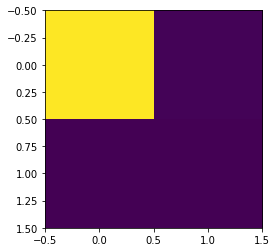

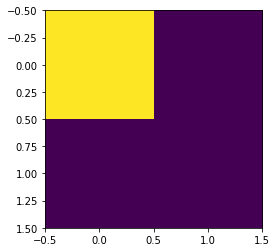

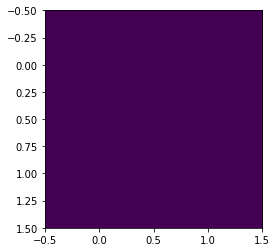

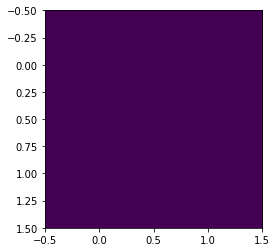

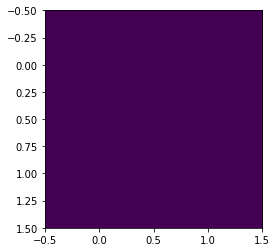

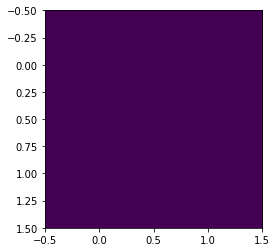

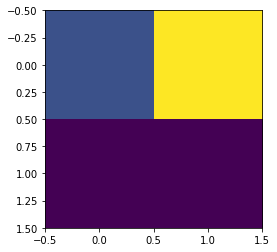

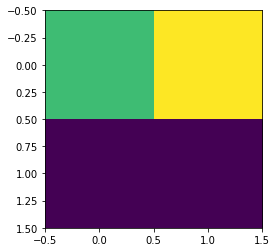

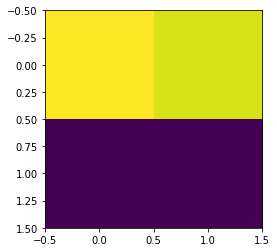

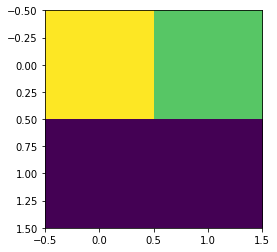

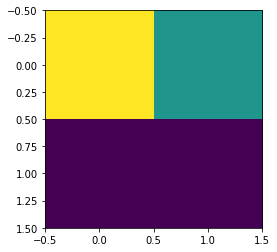

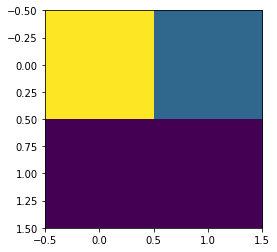

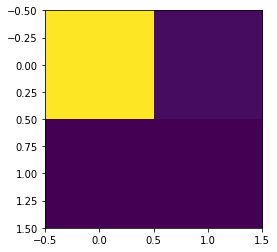

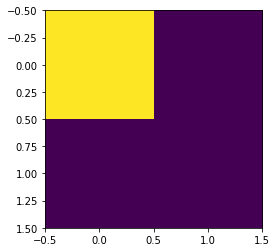

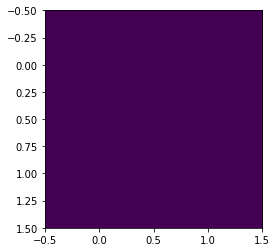

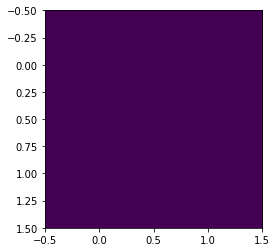

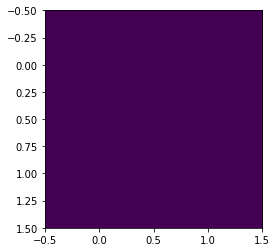

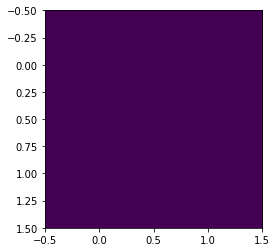

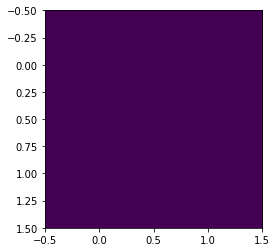

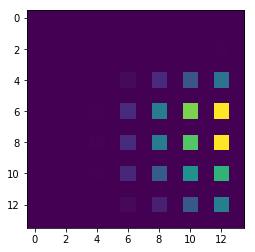

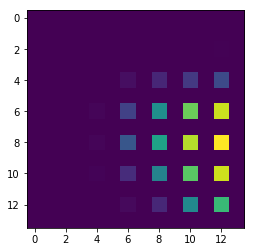

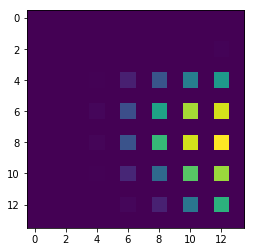

In [37]:
n = x_train[0].reshape([28, 28])
plt.figure()
plt.imshow(n)
conv_layer_1 = conv_layer(x_train[0], num_filters = 4, filter_size = 3, padding = 2, stride = 2)
layer_output_1 = conv_layer_1.forward_pass(x_train[0])
conv_layer_2 = conv_layer(layer_output_1, num_filters = 5, filter_size = 3, padding = 2, stride = 1)
layer_output_2 = conv_layer_2.forward_pass(layer_output_1)
conv_layer_3 = conv_layer(layer_output_2, num_filters = 3, filter_size = 3, padding = 2, stride = 1)
layer_output_3 = conv_layer_3.forward_pass(layer_output_2)
max_pooling_layer_1, mp_backward = max_pooling_layer(layer_output_3, filter_size = 2, stride = 2)
fc_layer = fully_connected_layer(max_pooling_layer_1, num_classes = 10)
fc_output = fc_layer.forward_pass(max_pooling_layer_1)

### Model Training: Forward pass, backpropagation and update

In [ ]:
params = {'num_epochs': 2, 'dropout':0.5, 'beta1': 0.9, 
          'beta2': 0.999, 'eps': 1e-8, }

In [ ]:
def convolution_backward(curr_layer, prev_layer, next_layer, stride, padding):
def maxpooling_backward(curr_layer, prev_layer, stride, padding):

In [ ]:
def calculate_gradients(img, y):
    
    dropout = params['dropout']
    loss = 0

    #Forward Pass
    layer_output_1 = conv_layer_1.forward_pass(img)
    layer_output_1 = dropout_layer(layer_output_1, dropout)
    
    layer_output_2 = conv_layer_2.forward_pass(layer_output_1)
    layer_output_2 = dropout_layer(layer_output_2, dropout)
    
    layer_output_3 = conv_layer_3.forward_pass(layer_output_2)
    layer_output_3 = dropout_layer(layer_output_3, dropout)
    
    max_pooling_layer_1, mp_layer1_backward = max_pooling_layer(layer_output_3, filter_size = 2, stride = 2)
    
    fc_output = fc_layer.forward_pass(max_pooling_layer_1)
    fc_logits = softmax_layer(fc_output)

    #Calculate loss
    log_likelihood = -y*np.log(fc_logits)
    loss += np.sum(log_likelihood)
    
    #Backward Pass
    dout = fc_logits - y
    
    ##FC Backward Pass
    dfc = fc_layer.fc_layer.T.dot(dout)
    dfc[fc_output <= 0] = 0
    
    ##FC Backward Pass
    mp_fc_input = max_pooling_layer_1.reshape((max_pooling_layer_1.shape[0] * max_pooling_layer_1.shape[1] * max_pooling_layer_1.shape[2], 1))
    dwfc = dfc.dot(mp_fc_input.T)
    dbfc = np.sum(dfc_output, axis = 1).reshape(fc_layer.fc_bias.shape)
    
    ##Maxpooling Backward Pass is just mp_layer1_backward
    
    
    ##Conv layer 3 Backward Pass
    dconv3 = convolution_backward()
    

    print("Loss {}th image::{}".format(t, loss))

In [ ]:
def train_step(img, y, t, prev_grad):
    beta1 = params['beta1']
    beta2 = params['beta2']
    eps = params['eps']
    lr = params['lr']
    
    #Calculate gradient vector
    # grad_fc_layer = 
    
    #Adam update with bias correction
    prev_grad = beta1*prev_grad + (1-beta1)*dx
    mt = prev_grad / (1-beta1**t)
    v = beta2*v + (1-beta2)*(dx**2)
    vt = v / (1-beta2**t)
    x += - lr * mt / (np.sqrt(vt) + eps)

## Random testing

In [ ]:
# n = (10 - 3 + 2)/2 +1
# int(n)

l = [np.stack([[1,2],[4,5],[7,8]]), np.stack([[10, 11], [13, 14], [16, 17]]), np.stack([[19, 20], [22, 23], [25, 26]])]
m = np.dstack(l)
print(m)
print(m.shape)
print(m)

print(plt.imshow(x_train[0][:,:,0]))

In [ ]:
f = np.arange(784).reshape([28, 28, 1])
c = np.arange(9).reshape([3, 3, 1])
filter_output = np.zeros([14,14])
s = 0
for i in range(0, f.shape[0], 2):
    t = 0
    for j in range(0, f.shape[1], 2):
        z = np.zeros([3, 3, f.shape[2]])
        z = np.asarray([[np.zeros(f.shape[2]) if m not in range(f.shape[0]) or n not in range(f.shape[1]) 
              else f[m, n] for n in range(j-int(c.shape[0]/2), j+int(c.shape[0]/2)+1)] 
                        for m in range(i-int(c.shape[0]/2), i+int(c.shape[0]/2)+1)])
        buffer_output = np.asarray([z[m, n, l]*c[m, n, l] for m, n, l in np.ndindex(c.shape)])
        print(z)
        print(c)
        print(buffer_output)
        filter_output[s, t] =  np.sum(buffer_output)
        print(filter_output)
        t += 1
    s += 1
print(filter_output)

In [ ]:
def create_conv_layer(img, num_filters, filter_size):
    cnn_layer = np.random.randn(num_filters, filter_size, filter_size, img.shape[2])
    return cnn_layer

In [ ]:
def convolve(img, cnn_filter, padding, stride):
    out_size = int((img.shape[0] - cnn_filter.shape[0] + 2*padding)/stride + 1)
    activation_map = np.zeros([out_size, out_size])
    s = t = 0
    for i in range(0, img.shape[0], stride):
        for j in range(0, img.shape[1], stride):
            z = np.zeros(cnn_filter.shape)
            z = np.asarray([[np.zeros(img.shape[2]) if m not in range(img.shape[0]) or n not in range(img.shape[1]) 
                  else img[m, n] for n in range(j-padding, j+padding+1)] for m in range(i-padding, i+padding+1)])
            buffer_output = np.asarray([z[m, n, l]*cnn_filter[m, n, l] for m, n, l in np.ndindex(cnn_filter.shape)])
            activation_map[s, t] =  np.sum(buffer_output)
            t += stride
        s += stride
    return activation_map

In [ ]:
def layer_conv(img, cnn_layer, stride = 1, padding = 0):
    out_size = int((img.shape[0] - cnn_layer.shape[1] + 2*padding)/stride + 1)
    layer_output = np.zeros([out_size, out_size, cnn_layer.shape[0]])
    for cnn_filter in cnn_layer:
        layer_output.append(convolve(img, cnn_filter, padding, stride))
    print(layer_output.shape)
    return layer_output

In [ ]:
m = np.random.randn(3, 3, 3, 3)
for n in m:
    print(n)

In [51]:
logits = np.random.rand(10, 1)
y = y_train[0].reshape((10, 1))
print('y shape::',y.shape)
dfc_output = logits - y
dfc_output[fc_output <= 0] = 0
print("fc_output::", fc_output)
print("dfc_output::", dfc_output)
dbfc = np.sum(dfc_output, axis = 1).reshape(fc_layer.fc_bias.shape)
print("dfc_output.shape::", dfc_output.shape)
mp_fc_input = max_pooling_layer_1.reshape((max_pooling_layer_1.shape[0] * max_pooling_layer_1.shape[1] * max_pooling_layer_1.shape[2], 1))
dwfc = dfc_output.dot(mp_fc_input.T)
print("dwfc.shape::", dwfc.shape)
print("maxpooling backward shape::", mp_backward.shape)

# print(dwfc.shape)
# dmp = mp_backward.dot(dwfc)

y shape:: (10, 1)
fc_output:: [[7.41924307e-07]
 [7.02114545e-07]
 [7.15238913e-07]
 [6.85828311e-07]
 [6.80839581e-07]
 [8.48651980e-07]
 [7.78425729e-07]
 [8.27336697e-07]
 [6.74952498e-07]
 [7.81226004e-07]]
dfc_output:: [[ 0.91076238]
 [ 0.4251046 ]
 [ 0.7166195 ]
 [ 0.80583613]
 [ 0.76421246]
 [-0.63268379]
 [ 0.87409526]
 [ 0.0440448 ]
 [ 0.40024687]
 [ 0.16259913]]
dfc_output.shape:: (10, 1)
dwfc.shape:: (10, 588)
maxpooling backward shape:: (28, 28, 3)


In [45]:
for layer in img_layers:
    layer_output = np.zeros([out_size, out_size])
    layer_backward_output = np.zeros([layer.shape[0], layer.shape[1]])
    print("LOShape::", layer_output.shape)
    s = 0
    for i in range(0, layer.shape[0], stride):
        t = 0
        for j in range(0, layer.shape[1], stride):
    #                 print(i, j)
            if filter_size%2 !=0 :
                z = np.asarray([[0 if m not in range(layer.shape[0]) or n not in range(layer.shape[1]) 
                            else layer[m, n] for n in range(j - int(filter_size/2), j + int(filter_size/2) + 1)]
                           for m in range(i - int(filter_size/2), i + int(filter_size/2) + 1)])
            else:
                z = np.asarray([[0 if m not in range(layer.shape[0]) or n not in range(layer.shape[1]) 
                            else layer[m, n] for n in range(j, j + int(filter_size/2) + 1)]
                           for m in range(i, i + int(filter_size/2) + 1)])
    #                 print("Window from ({}, {}) to ({}, {})".format(i, j, i + int(filter_size/2), j + int(filter_size/2)))
            plt.figure()
            plt.imshow(z)
            buffer_output = np.max(z)
            if (t < out_size) and (s < out_size):
                layer_output[s, t] = buffer_output
            layer_backward_output[s, t] = buffer_output 
            t += stride
        s += stride
    full_layer_output.append(layer_output)
    full_layer_backward.append(layer_backward_output)

NameError: name 'img_layers' is not defined